**Table of contents**<a id='toc0_'></a>    
- [Imports & Setup](#toc1_1_1_)    
    - [Preparation of the three datasets (Industrial, School and Residential)](#toc1_1_2_)    
      - [Removal of the Timestamp Column and Cumulative Import](#toc1_1_2_1_)    
      - [Charts and Statistics](#toc1_1_2_2_)    
      - [Date Conversion](#toc1_1_2_3_)    
      - [Analysis of Optimal Frequencies Using Fourier Transforms](#toc1_1_2_4_)    
      - [Adding Optimal Frequencies](#toc1_1_2_5_)    
      - [Dataset Split](#toc1_1_2_6_)    
      - [Data Normalization](#toc1_1_2_7_)    
    - [Data Windowing](#toc1_1_3_)    
    - [Training](#toc1_1_4_)    
      - [Single Step Models](#toc1_1_4_1_)    
        - [Linear Model](#toc1_1_4_1_1_)    
        - [Recurrent Neural Network](#toc1_1_4_1_2_)    
        - [Single step models performances](#toc1_1_4_1_3_)    
      - [Multi-Step Models](#toc1_1_4_2_)    
        - [Linear Model](#toc1_1_4_2_1_)    
        - [Dense Model](#toc1_1_4_2_2_)    
        - [CNN Model](#toc1_1_4_2_3_)    
        - [RNN Model](#toc1_1_4_2_4_)    
        - [Autoregressive RNN Model](#toc1_1_4_2_5_)    
        - [Multi Step Models Performances](#toc1_1_4_2_6_)    
    - [Chosen Approach for Frequencies](#toc1_1_5_)    
    - [Conclusions](#toc1_1_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_1_'></a>[Imports & Setup](#toc0_)

In [1]:
import os
import datetime
import math

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams["figure.figsize"] = (8, 6)
mpl.rcParams["axes.grid"] = False

2024-04-22 09:42:08.696771: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-22 09:42:08.698718: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-22 09:42:08.770801: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-22 09:42:09.078882: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 09:42:10.662432: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

### <a id='toc1_1_2_'></a>[Preparation of the three datasets (Industrial, School and Residential)](#toc0_)

In [2]:
import pandas as pd

df = pd.read_csv(
    "opsd-household_data-2020-04-15/household_data_15min_singleindex.csv"
)

df_industrial = df.copy()
df_residential = df.copy()
df_school = df.copy()

timestamp_column = "utc_timestamp"

data_column_industrial = "DE_KN_industrial1_grid_import"
data_column_school = "DE_KN_public1_grid_import"
data_column_residential = "DE_KN_residential1_grid_import"

df_industrial = df_industrial[[timestamp_column, data_column_industrial]]
df_residential = df_residential[[timestamp_column, data_column_residential]]
df_school = df_school[[timestamp_column, data_column_school]]

# The difference between one value and the one before in the import column gives us the instantaneous import
df_industrial[f"{data_column_industrial}_instantaneous"] = df_industrial[
    data_column_industrial
].diff()
df_residential[f"{data_column_residential}_instantaneous"] = df_residential[
    data_column_residential
].diff()
df_school[f"{data_column_school}_instantaneous"] = df_school[data_column_school].diff()


# Removes rows with null fields
df_industrial.dropna(inplace=True)
df_residential.dropna(inplace=True)
df_school.dropna(inplace=True)

df_industrial
df_residential
df_school

utc_timestamp  DE_KN_public1_grid_import  \
50178  2016-05-17T10:15:00Z                      0.428   
50179  2016-05-17T10:30:00Z                      0.755   
50180  2016-05-17T10:45:00Z                      1.105   
50181  2016-05-17T11:00:00Z                      1.695   
50182  2016-05-17T11:15:00Z                      2.166   
...                     ...                        ...   
68369  2016-11-22T22:00:00Z                  12312.401   
68370  2016-11-22T22:15:00Z                  12312.767   
68371  2016-11-22T22:30:00Z                  12313.153   
68372  2016-11-22T22:45:00Z                  12313.510   
68373  2016-11-22T23:00:00Z                  12313.546   

       DE_KN_public1_grid_import_instantaneous  
50178                                    0.395  
50179                                    0.327  
50180                                    0.350  
50181                                    0.590  
50182                                    0.471  
...                                        ...  
68369                                    0.352  
68370                                    0.366  
68371                                    0.386  
68372                                    0.357  
68373                                    0.036  

[18196 rows x 3 columns]

#### <a id='toc1_1_2_1_'></a>[Removal of the Timestamp Column and Cumulative Import](#toc0_)

We'll remove the timestamp column because it is a string, and therefore should always be excluded when calculating means, standard deviations, and when creating graphs that we will make later on the datasets. This value will be reintroduced later as a purely numerical value.

We are also removing the cumulative import column because it is not necessary for the model.

In [3]:
date_time_industrial = pd.to_datetime(
    df_industrial.pop(timestamp_column), format="ISO8601"
)

date_time_residential = pd.to_datetime(
    df_residential.pop(timestamp_column), format="ISO8601"
)

date_time_school = pd.to_datetime(df_school.pop(timestamp_column), format="ISO8601")

# Removal of the cumulative import column

cumulative_import_industrial = df_industrial.pop(data_column_industrial)

cumulative_import_residential = df_residential.pop(data_column_residential)

cumulative_import_school = df_school.pop(data_column_school)

#### <a id='toc1_1_2_2_'></a>[Charts and Statistics](#toc0_)

In [4]:
# # Uncomment to plot new charts
# plot_cols = [data_column_industrial, f"{data_column_industrial}_instantaneous"]
# plot_features = df_industrial[plot_cols][:5000]
# plot_features.index = date_time_industrial[:5000]
# _ = plot_features.plot(subplots=True)

# plot_cols = [data_column_residential, f"{data_column_residential}_instantaneous"]
# plot_features = df_residential[plot_cols][:5000]
# plot_features.index = date_time_residential[:5000]
# _ = plot_features.plot(subplots=True)

# plot_cols = [data_column_school, f"{data_column_school}_instantaneous"]
# plot_features = df_school[plot_cols][:5000]
# plot_features.index = date_time_school[:5000]
# _ = plot_features.plot(subplots=True)

![Grid Import Industrial](resources/industrial_grid_import_15min.png "Grid Import Industrial")

![Grid Import Residential](resources/residential_grid_import_15min.png "Grid Import Residential")

![Grid Import School](resources/school_grid_import_15min.png "Grid Import School")

In [5]:
df_industrial.describe().transpose()

count      mean       std  \
DE_KN_industrial1_grid_import_instantaneous  65729.0  7.776053  4.745445   

                                               min    25%    50%     75%  \
DE_KN_industrial1_grid_import_instantaneous  0.688  4.391  6.875  10.125   

                                                max  
DE_KN_industrial1_grid_import_instantaneous  40.828

In [6]:
df_residential.describe().transpose()

count      mean       std  \
DE_KN_residential1_grid_import_instantaneous  63486.0  0.143281  0.115451   

                                                min   25%   50%    75%    max  
DE_KN_residential1_grid_import_instantaneous  0.029  0.09  0.11  0.145  1.663

In [7]:
df_school.describe().transpose()

count      mean       std    min  \
DE_KN_public1_grid_import_instantaneous  18196.0  0.676715  0.757493  0.036   

                                           25%    50%    75%    max  
DE_KN_public1_grid_import_instantaneous  0.279  0.361  0.615  5.113

Once we have visualized the data contained in the datasets and measures such as standard deviation, minimums, and maximums, we can assess the quality of the dataset and possibly eliminate null or incorrect data (for example, if we notice minimums or maximums that do not make sense). In this case, apart from the removal of empty fields already carried out, we can keep the datasets as they are.

#### <a id='toc1_1_2_3_'></a>[Date Conversion](#toc0_)

To optimize model performance, it makes sense to pass the year period and time of day to the model instead of the date or timestamp, as energy usage varies based on these two frequencies.

In [8]:
day = 24 * 60 * 60
# By considering the actual length of a year (365.2425 days), we do not need to account for leap years.
year = (365.2425) * day

timestamp_seconds_industrial = date_time_industrial.map(pd.Timestamp.timestamp)

df_industrial["Day sin"] = np.sin(timestamp_seconds_industrial * (2 * np.pi / day))
df_industrial["Day cos"] = np.cos(timestamp_seconds_industrial * (2 * np.pi / day))
df_industrial["Year sin"] = np.sin(timestamp_seconds_industrial * (2 * np.pi / year))
df_industrial["Year cos"] = np.cos(timestamp_seconds_industrial * (2 * np.pi / year))

timestamp_seconds_residential = date_time_residential.map(pd.Timestamp.timestamp)

df_residential["Day sin"] = np.sin(timestamp_seconds_residential * (2 * np.pi / day))
df_residential["Day cos"] = np.cos(timestamp_seconds_residential * (2 * np.pi / day))
df_residential["Year sin"] = np.sin(timestamp_seconds_residential * (2 * np.pi / year))
df_residential["Year cos"] = np.cos(timestamp_seconds_residential * (2 * np.pi / year))

timestamp_seconds_school = date_time_industrial.map(pd.Timestamp.timestamp)

df_school["Day sin"] = np.sin(timestamp_seconds_school * (2 * np.pi / day))
df_school["Day cos"] = np.cos(timestamp_seconds_school * (2 * np.pi / day))
df_school["Year sin"] = np.sin(timestamp_seconds_school * (2 * np.pi / year))
df_school["Year cos"] = np.cos(timestamp_seconds_school * (2 * np.pi / year))

# # Uncomment to plot new charts
# plot_cols = ['Day sin', 'Day cos']
# plot_features = df_industrial[plot_cols][:96]
# plot_features.index = date_time_industrial[:96]
# _ = plot_features.plot(subplots=True)

# plot_cols = ['Year sin', 'Year cos']
# plot_features = df_industrial[plot_cols][:35064]
# plot_features.index = date_time_industrial[:35064]
# _ = plot_features.plot(subplots=True)

![Segnale Seno e Coseno Timestamp Periodo Giornaliero](resources/timestamp_day_encoding.png "Segnale Seno e Coseno Timestamp Periodo Giornaliero")
![Segnale Seno e Coseno Timestamp Periodo Annuale](resources/timestamp_year_encoding.png "Segnale Seno e Coseno Timestamp Periodo Annuale")

#### <a id='toc1_1_2_4_'></a>[Analysis of Optimal Frequencies Using Fourier Transforms](#toc0_)

We do not necessarily have to use daily and annual periods to encode the timestamps in the datasets; depending on the dataset or use case, there may be better frequencies. To identify these frequencies, we can apply Fourier transforms to the recorded data and look for the frequencies that have the most significant impact on the final result.

__Note__: The issue of __gaps in the datasets__ needs further investigation. If not removed, these gaps prevent the execution of Fourier transforms. Even if we remove them and perform the Fourier transforms, if the gaps are too large, the final results may be distorted.

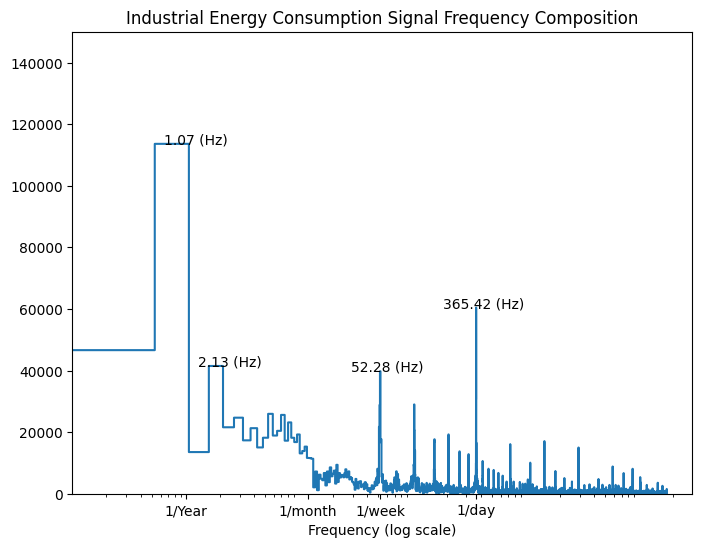

In [9]:
fft = tf.signal.rfft(df_industrial[f"{data_column_industrial}_instantaneous"])
f_per_dataset = np.arange(0, len(fft))

n_samples = len(df_industrial[f"{data_column_industrial}_instantaneous"])
# Calculate the number of quarters in a year since we have a sample every quarter-hour
hours_quarters_per_year = 24 * 365.2524 * 4
years_per_dataset = n_samples / (hours_quarters_per_year)

f_per_year = f_per_dataset / years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale("log")
plt.ylim(0, 150000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks(
    [1, 12, 365.2524 / 7, 365.2524], labels=["1/Year", "1/month", "1/week", "1/day"]
)
_ = plt.xlabel("Frequency (log scale)")
_ = plt.title("Industrial Energy Consumption Signal Frequency Composition")

# Search for the maximum values of the frequency weights
candidate_indices = np.argsort(np.abs(fft))[::-1]  # Sort by magnitude descending
top_4_indices = []
for idx in candidate_indices:
    if f_per_year[idx] >= 1 and not any(
        [
            # TODO do some futher research on the use of log(last_frequency) to get "well spaced" frequencies
            abs(f_per_year[idx] - last_frequency) < math.log(last_frequency)
            for last_frequency in f_per_year[top_4_indices]
        ]
        if top_4_indices
        else [False]
    ):
        top_4_indices.append(idx)
        if len(top_4_indices) == 4:
            break  # Stop after finding 4 valid frequencies
top_4_frequencies_industrial = f_per_year[top_4_indices]
top_4_magnitudes = np.abs(fft)[top_4_indices]
# Annotate top 4 peaks
for i, (freq, mag) in enumerate(zip(top_4_frequencies_industrial, top_4_magnitudes)):
    plt.annotate(
        f"{freq:.2f} (Hz)",
        (freq, mag),
        xytext=(5, 0),
        textcoords="offset points",
        ha="center",
    )

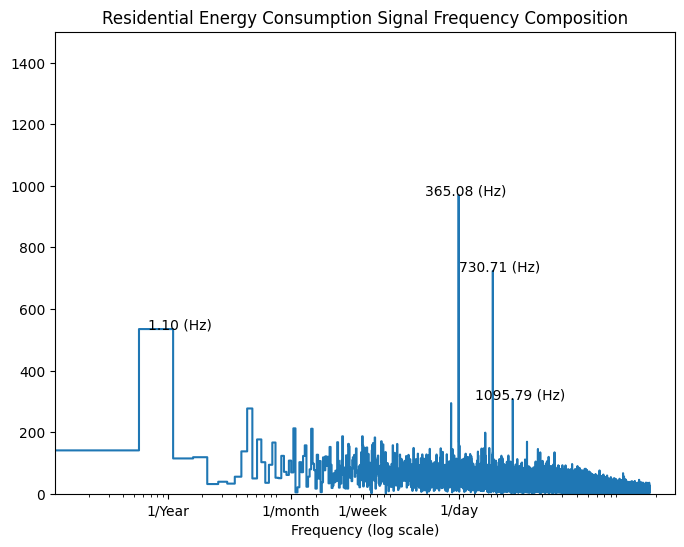

In [10]:
fft = tf.signal.rfft(df_residential[f"{data_column_residential}_instantaneous"])
f_per_dataset = np.arange(0, len(fft))

n_samples = len(df_residential[f"{data_column_residential}_instantaneous"])
hours_quarters_per_year = 24 * 365.2524 * 4
years_per_dataset = n_samples / (hours_quarters_per_year)

f_per_year = f_per_dataset / years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale("log")
plt.ylim(0, 1500)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks(
    [1, 12, 365.2524 / 7, 365.2524], labels=["1/Year", "1/month", "1/week", "1/day"]
)
_ = plt.xlabel("Frequency (log scale)")
_ = plt.title("Residential Energy Consumption Signal Frequency Composition")


# Search for the maximum values of the frequency weights
candidate_indices = np.argsort(np.abs(fft))[::-1]  # Sort by magnitude descending
top_4_indices = []
for idx in candidate_indices:
    if f_per_year[idx] >= 1 and not any(
        [
            # TODO do some futher research on the use of log(last_frequency) to get "well spaced" frequencies
            abs(f_per_year[idx] - last_frequency) < math.log(last_frequency)
            for last_frequency in f_per_year[top_4_indices]
        ]
        if top_4_indices
        else [False]
    ):
        top_4_indices.append(idx)
        if len(top_4_indices) == 4:
            break  # Stop after finding 4 valid frequencies
top_4_frequencies_residential = f_per_year[top_4_indices]
top_4_magnitudes = np.abs(fft)[top_4_indices]
# Annotate top 4 peaks
for i, (freq, mag) in enumerate(zip(top_4_frequencies_residential, top_4_magnitudes)):
    plt.annotate(
        f"{freq:.2f} (Hz)",
        (freq, mag),
        xytext=(5, 0),
        textcoords="offset points",
        ha="center",
    )

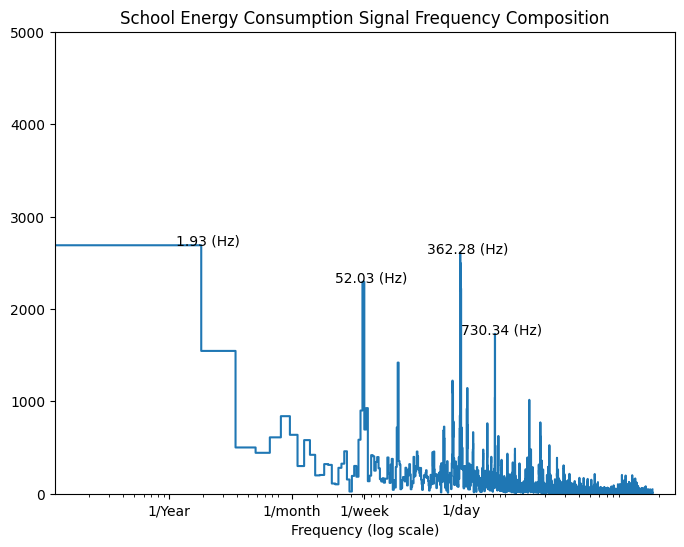

In [11]:
fft = tf.signal.rfft(df_school[f"{data_column_school}_instantaneous"])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df_school[f"{data_column_school}_instantaneous"])
hours_quarters_per_year = 24 * 365.2524 * 4
years_per_dataset = n_samples_h / (hours_quarters_per_year)

f_per_year = f_per_dataset / years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale("log")
plt.ylim(0, 5000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks(
    [1, 12, 365.2524 / 7, 365.2524], labels=["1/Year", "1/month", "1/week", "1/day"]
)
_ = plt.xlabel("Frequency (log scale)")
_ = plt.title("School Energy Consumption Signal Frequency Composition")


# Search for the maximum values of the frequency weights
candidate_indices = np.argsort(np.abs(fft))[::-1]  # Sort by magnitude descending
top_4_indices = []
for idx in candidate_indices:
    if f_per_year[idx] >= 1 and not any(
        [
            # TODO do some futher research on the use of log(last_frequency) to get "well spaced" frequencies
            abs(f_per_year[idx] - last_frequency) < math.log(last_frequency)
            for last_frequency in f_per_year[top_4_indices]
        ]
        if top_4_indices
        else [False]
    ):
        top_4_indices.append(idx)
        if len(top_4_indices) == 4:
            break  # Stop after finding 4 valid frequencies
top_4_frequencies_school = f_per_year[top_4_indices]
top_4_magnitudes = np.abs(fft)[top_4_indices]
# Annotate top 4 peaks
for i, (freq, mag) in enumerate(zip(top_4_frequencies_school, top_4_magnitudes)):
    plt.annotate(
        f"{freq:.2f} (Hz)",
        (freq, mag),
        xytext=(5, 0),
        textcoords="offset points",
        ha="center",
    )

In [12]:
column_names = ["Industrial", "Residential", "School"]

best_frequencies_results = pd.DataFrame(
    [
        [
            top_4_frequencies_industrial[0],
            top_4_frequencies_residential[0],
            top_4_frequencies_school[0],
        ],
        [
            top_4_frequencies_industrial[1],
            top_4_frequencies_residential[1],
            top_4_frequencies_school[1],
        ],
        [
            top_4_frequencies_industrial[2],
            top_4_frequencies_residential[2],
            top_4_frequencies_school[2],
        ],
        [
            top_4_frequencies_industrial[3],
            top_4_frequencies_residential[3],
            top_4_frequencies_school[3],
        ],
    ],
    columns=column_names,
)

best_frequencies_results

Industrial  Residential      School
0    1.066933   365.079802    1.927030
1  365.424665   730.711918  362.281563
2    2.133867     1.104629   52.029799
3   52.279733  1095.791720  730.344214

We can observe that the most significant frequencies for each dataset are not immediately obvious. The initial choice to use the period of the year and time of day (i.e., (Year sin, Year cos) and (Day sin, Day cos)) is a good choice for all datasets: as expected, energy consumption is influenced by the time of year and time of day. However, the data reveals that each dataset has other dominant frequencies (such as weekly (~ 52 Hz) or bi-daily (~ 730 Hz)) and that the order of importance of these frequencies varies across datasets.

It is important to consider an aspect of the automated search for these maxima; these maxima are the result of a further filtering operation relative to the real maxima, considering the significance of the data:
- Maxima < 1 were excluded, as we do not expect the data to exhibit any cyclicity over periods longer than 1 year.
- Local maxima rather than absolute maxima were considered. If a maximum was found near (within log(max)) an already identified maximum, it was not considered, and only the greater of the two was taken. This approach allows for well-distributed final frequencies, taking into account both shorter and longer cyclicities.

__Note__: The reported frequency values are not the real ones, as __the frequencies are normalized__ based on the number of years recorded in the datasets and are thus relative to 1 year:
```python
f_per_year = f_per_dataset / years_per_dataset
```

__Note__: Frequencies higher than the daily one are difficult to interpret since they imply that consumption patterns repeat similarly within the same day. For example, the bi-daily frequency (~ 730 Hz) might indicate a correlation between consumption patterns in the first part of the day and those in the second part of the day.

#### <a id='toc1_1_2_5_'></a>[Adding Optimal Frequencies](#toc0_)

At this point, we can adopt two approaches: derive "ideal" frequencies from the results found, effectively interpreting the data (for example, if we have a result ~ 52 Hz, we interpret this as a weekly frequency and add 'Week cos' and 'Week sin' to the dataset using the number of seconds in a week, as done previously for the year and day), or use those frequencies directly to determine the sine and cosine periods we will use to convert the timestamp, independent of the normal division of time into days, weeks, months, years...

In [13]:
# Interpretative Approach

week = 24 * 60 * 60 * 7
half_day = 12 * 60 * 60
semester = (365.2425) * half_day

"""
Industrial Dataset: Top 3 Frequencies
- 1.066933 Hz ~ 1 Hz -> Annual
- 365.424665 Hz ~ 365 Hz -> Daily
- 2.133867 Hz ~ 2 Hz -> Bi-monthly
"""

df_industrial["Semester sin"] = np.sin(
    timestamp_seconds_industrial * (2 * np.pi / semester)
)
df_industrial["Semester cos"] = np.cos(
    timestamp_seconds_industrial * (2 * np.pi / semester)
)

"""
Residential Dataset: Top 3 Frequencies
- 365.079802 Hz ~ 365 Hz -> Daily
- 730.711918 Hz ~ 730 Hz -> Bi-daily
- 1.104629 Hz ~ 1 Hz -> Annual
"""

df_residential["Half-Day sin"] = np.sin(
    timestamp_seconds_residential * (2 * np.pi / half_day)
)
df_residential["Half-Day cos"] = np.cos(
    timestamp_seconds_residential * (2 * np.pi / half_day)
)

"""
School Dataset: Top 3 Frequencies
- 1.92703 Hz ~ 1 Hz -> Annual; here the frequency is closer to 2 Hz than to 1 Hz, but since
energy consumption commonly seems to have a more annual period rather than semi-annual, it was decided to
use the annual frequency anyway. This result could be justified by a much smaller dataset compared to the other two.
- 362.281563 Hz ~ 365 Hz -> Daily
- 52.029799 Hz ~ 52 Hz -> Weekly
"""

df_school["Week sin"] = np.sin(timestamp_seconds_school * (2 * np.pi / week))
df_school["Week cos"] = np.cos(timestamp_seconds_school * (2 * np.pi / week))

# # Uncomment to plot new charts
# plot_cols = ['Semester sin', 'Semester cos']
# plot_features = df_industrial[plot_cols][:17532]
# plot_features.index = date_time_industrial[:17532]
# _ = plot_features.plot(subplots=True)

# plot_cols = ['Half-Day sin', 'Half-Day cos']
# plot_features = df_residential[plot_cols][:48]
# plot_features.index = date_time_residential[:48]
# _ = plot_features.plot(subplots=True)

# plot_cols = ['Week sin', 'Week cos']
# plot_features = df_school[plot_cols][:672]
# plot_features.index = date_time_school[:672]
# _ = plot_features.plot(subplots=True)

![Segnale Seno e Coseno Timestamp Periodo Settimanale](resources/timestamp_week_encoding.png "Segnale Seno e Coseno Timestamp Periodo Settimanale")
![Segnale Seno e Coseno Timestamp Periodo Semestrale](resources/timestamp_semester_encoding.png "Segnale Seno e Coseno Timestamp Periodo Semestrale")
![Segnale Seno e Coseno Timestamp Periodo Bi-Giornaliero](resources/timestamp_half_day_encoding.png "Segnale Seno e Coseno Timestamp Periodo Bi-Giornaliero")

In [14]:
# # Naive Approach

# columns_industrial = df_industrial.columns
# for column in columns_industrial:
#     if column.endswith('cos') or column.endswith('sin'):
#         df_industrial.pop(column)

# for i, frequency in enumerate(best_frequencies_results['Industrial']):
#     if i < 3: # prendiamo solo le top 3 frequenze
#         df_industrial[f'Frequency {i + 1} sin'] = np.sin(timestamp_seconds_industrial * (2 * np.pi / (year/frequency))) # year / frequency = n secondi
#         df_industrial[f'Frequency {i + 1} cos'] = np.cos(timestamp_seconds_industrial * (2 * np.pi / (year/frequency))) # year / frequency = n secondi

# columns_residential = df_residential.columns
# for column in columns_residential:
#     if column.endswith('cos') or column.endswith('sin'):
#         df_residential.pop(column)

# for i, frequency in enumerate(best_frequencies_results['Residential']):
#     if i < 3: # prendiamo solo le top 3 frequenze
#         df_residential[f'Frequency {i + 1} sin'] = np.sin(timestamp_seconds_residential * (2 * np.pi / (year/frequency))) # year / frequency = n secondi
#         df_residential[f'Frequency {i + 1} cos'] = np.cos(timestamp_seconds_residential * (2 * np.pi / (year/frequency))) # year / frequency = n secondi

# columns_school = df_school.columns
# for column in columns_school:
#     if column.endswith('cos') or column.endswith('sin'):
#         df_school.pop(column)

# for i, frequency in enumerate(best_frequencies_results['School']):
#     if i < 3: # prendiamo solo le top 3 frequenze
#         df_school[f'Frequency {i + 1} sin'] = np.sin(timestamp_seconds_school * (2 * np.pi / (year/frequency))) # year / frequency = n secondi
#         df_school[f'Frequency {i + 1} cos'] = np.cos(timestamp_seconds_school * (2 * np.pi / (year/frequency))) # year / frequency = n secondi

#### <a id='toc1_1_2_6_'></a>[Dataset Split](#toc0_)

We will use a split of (70%, 20%, 10%) for the training, validation, and test sets. Note that the data is not shuffled randomly before splitting. This is for two reasons:

- It ensures that it is still possible to split the data into windows of consecutive samples.
- It ensures that the validation/test results are more realistic, being evaluated on data collected after the model has been trained.

In [15]:
column_indices_industrial = {name: i for i, name in enumerate(df_industrial.columns)}

n_industrial = len(df_industrial)
train_df_industrial = df_industrial[0 : int(n_industrial * 0.7)]
val_df_industrial = df_industrial[int(n_industrial * 0.7) : int(n_industrial * 0.9)]
test_df_industrial = df_industrial[int(n_industrial * 0.9) :]

num_features_industrial = df_industrial.shape[1]

column_indices_residential = {name: i for i, name in enumerate(df_residential.columns)}

n_residential = len(df_residential)
train_df_residential = df_residential[0 : int(n_residential * 0.7)]
val_df_residential = df_residential[int(n_residential * 0.7) : int(n_residential * 0.9)]
test_df_residential = df_residential[int(n_residential * 0.9) :]

num_features_residential = df_residential.shape[1]

column_indices_school = {name: i for i, name in enumerate(df_school.columns)}

n_school = len(df_school)
train_df_school = df_school[0 : int(n_school * 0.7)]
val_df_school = df_school[int(n_school * 0.7) : int(n_school * 0.9)]
test_df_school = df_school[int(n_school * 0.9) :]

num_features_school = df_school.shape[1]

In [16]:
# Stampa i nomi delle colonne dei dataset
# Prints the name of the datasets' columns
datasets_columns_indices = pd.DataFrame(
    [
        column_indices_industrial.keys(),
        column_indices_residential.keys(),
        column_indices_school.keys(),
    ]
).T
datasets_columns_indices.columns = column_names
datasets_columns_indices

Industrial  \
0  DE_KN_industrial1_grid_import_instantaneous   
1                                      Day sin   
2                                      Day cos   
3                                     Year sin   
4                                     Year cos   
5                                 Semester sin   
6                                 Semester cos   

                                    Residential  \
0  DE_KN_residential1_grid_import_instantaneous   
1                                       Day sin   
2                                       Day cos   
3                                      Year sin   
4                                      Year cos   
5                                  Half-Day sin   
6                                  Half-Day cos   

                                    School  
0  DE_KN_public1_grid_import_instantaneous  
1                                  Day sin  
2                                  Day cos  
3                                 Year sin  
4                                 Year cos  
5                                 Week sin  
6                                 Week cos

#### <a id='toc1_1_2_7_'></a>[Data Normalization](#toc0_)

We will perform normalization using mean and standard deviation. The mean and standard deviation should be calculated only using the training data so that the models do not have access to the values in the validation and test sets.

__Note__: In reality, normalization should ideally be performed using moving averages.

In [17]:
train_mean_industrial = train_df_industrial.mean()
train_std_industrial = train_df_industrial.std()
train_df_industrial = (
    train_df_industrial - train_mean_industrial
) / train_std_industrial
val_df_industrial = (val_df_industrial - train_mean_industrial) / train_std_industrial
test_df_industrial = (test_df_industrial - train_mean_industrial) / train_std_industrial

train_mean_residential = train_df_residential.mean()
train_std_residential = train_df_residential.std()
train_df_residential = (
    train_df_residential - train_mean_residential
) / train_std_residential
val_df_residential = (
    val_df_residential - train_mean_residential
) / train_std_residential
test_df_residential = (
    test_df_residential - train_mean_residential
) / train_std_residential

train_mean_school = train_df_school.mean()
train_std_school = train_df_school.std()
train_df_school = (train_df_school - train_mean_school) / train_std_school
val_df_school = (val_df_school - train_mean_school) / train_std_school
test_df_school = (test_df_school - train_mean_school) / train_std_school

/tmp/ipykernel_22104/2556769267.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df_industrial.keys(), rotation=90)


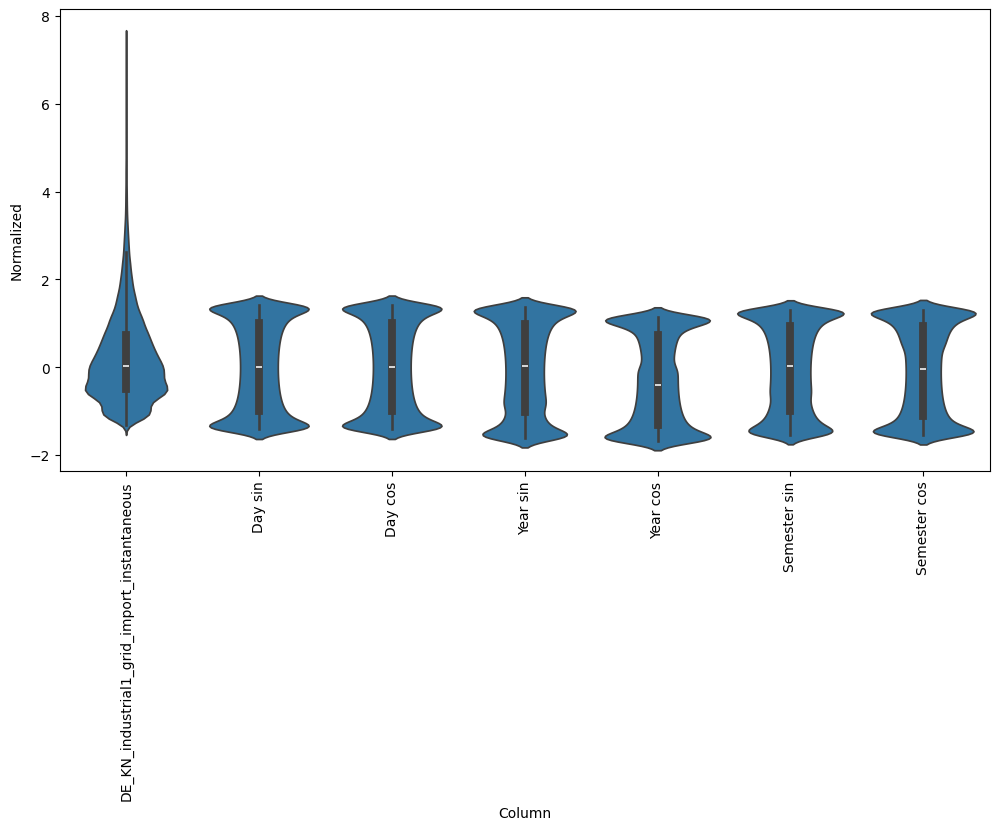

In [18]:
df_std_industrial = (df_industrial - train_mean_industrial) / train_std_industrial
df_std_industrial = df_std_industrial.melt(var_name="Column", value_name="Normalized")
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x="Column", y="Normalized", data=df_std_industrial)
_ = ax.set_xticklabels(df_industrial.keys(), rotation=90)

/tmp/ipykernel_22104/2186552112.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df_residential.keys(), rotation=90)


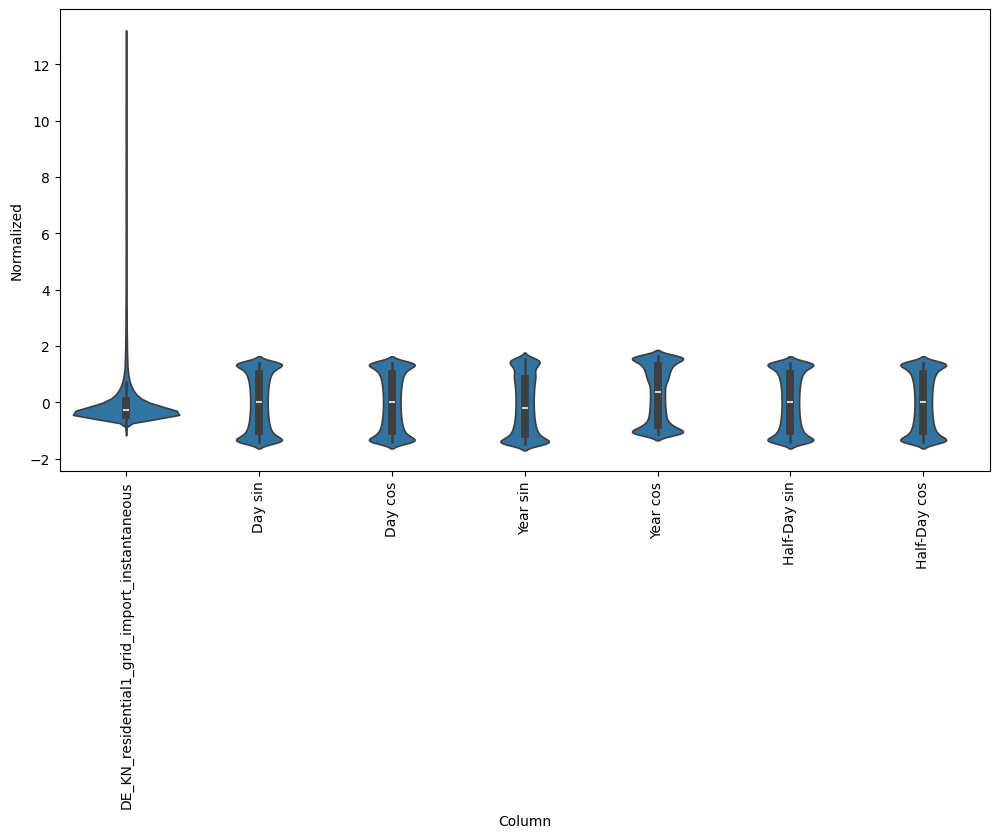

In [19]:
df_std_residential = (df_residential - train_mean_residential) / train_std_residential
df_std_residential = df_std_residential.melt(var_name="Column", value_name="Normalized")
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x="Column", y="Normalized", data=df_std_residential)
_ = ax.set_xticklabels(df_residential.keys(), rotation=90)

/tmp/ipykernel_22104/1413678702.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df_school.keys(), rotation=90)


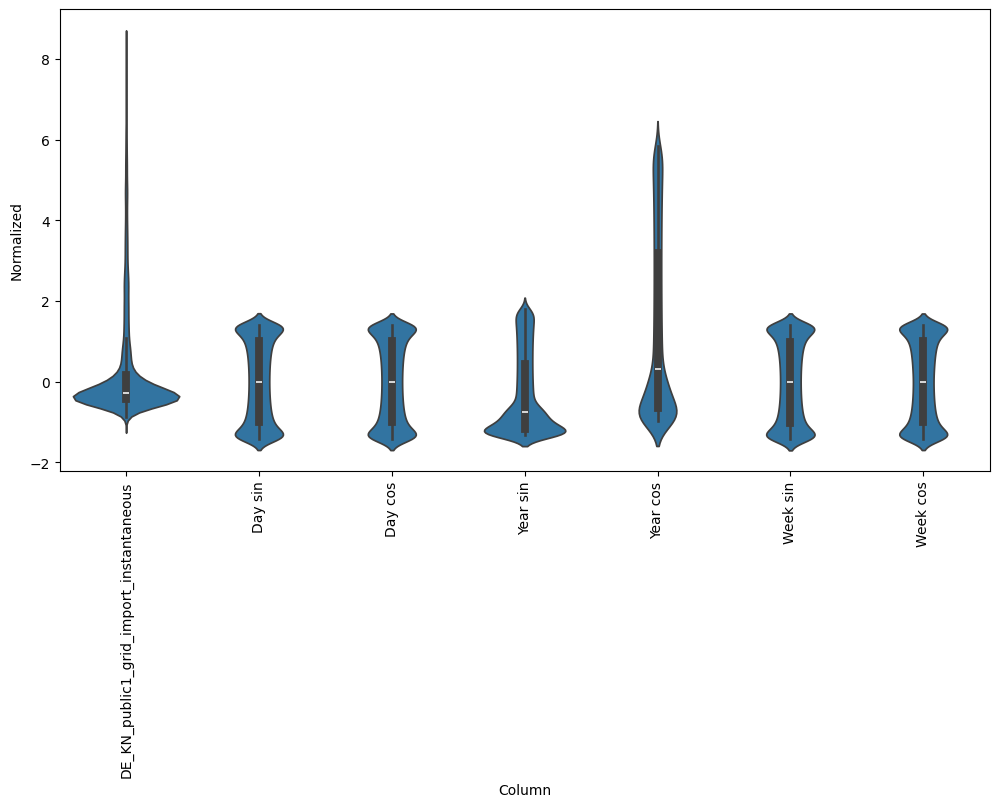

In [20]:
df_std_school = (df_school - train_mean_school) / train_std_school
df_std_school = df_std_school.melt(var_name="Column", value_name="Normalized")
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x="Column", y="Normalized", data=df_std_school)
_ = ax.set_xticklabels(df_school.keys(), rotation=90)

__Note__: The unexpected distribution of sine and cosine with an annual period in the school dataset is due to the presence of gaps in the dataset and their consequent removal, in fact when these gaps are not removed we get the expected distribution.

### <a id='toc1_1_3_'></a>[Data Windowing](#toc0_)

The models used will make predictions based on a window of measured data. The data windowing process is designed to prepare these windows for training, testing, and validating the models.

In [21]:
class WindowGenerator:
    def __init__(
        self,
        input_width,
        label_width,
        shift,
        train_df,
        val_df,
        test_df,
        label_columns=None,
    ):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return "\n".join(
            [
                f"Total window size: {self.total_window_size}",
                f"Input indices: {self.input_indices}",
                f"Label indices: {self.label_indices}",
                f"Label column name(s): {self.label_columns}",
            ]
        )

    def split_window(self, features):
        """
        Generates training batches from an input list, creating n batches of inputs and n batches of
        labels given len(features) = n

        Args:
        features (SymbolicTensor): list of consecutive inputs

        Returns:
        (( SymbolicTensor, SymbolicTensor )): tuple containing inputs and labels
        """

        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [
                    labels[:, :, self.column_indices[name]]
                    for name in self.label_columns
                ],
                axis=-1,
            )

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, plot_col: str, model=None, max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n + 1)
            if len(plot_col) < 11:
                plt.ylabel(f"{plot_col} [normed]")
            else:
                plt.ylabel(f"{plot_col[:8]}... [normed]")
            plt.plot(
                self.input_indices,
                inputs[n, :, plot_col_index],
                label="Inputs",
                marker=".",
                zorder=-10,
            )

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(
                self.label_indices,
                labels[n, :, label_col_index],
                edgecolors="k",
                label="Labels",
                c="#2ca02c",
                s=64,
            )
            if model is not None:
                predictions = model(inputs)
                plt.scatter(
                    self.label_indices,
                    predictions[n, :, label_col_index],
                    marker="X",
                    edgecolors="k",
                    label="Predictions",
                    c="#ff7f0e",
                    s=64,
                )

            if n == 0:
                plt.legend()

        plt.xlabel("Time [15 min]")

    def make_dataset(self, data):
        """
        Takes a time series in the form of a DataFrame and converts it into a
        tensorflow.data.Dataset of (input_window, label_window) pairs to be used in training

        Args:
          data (DataFrame): time series data

        Returns:
          (tensorflow.data.Dataset): dataset consisting of (input_window, label_window) pairs   
        """

        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,
        )

        ds = ds.map(self.split_window)

        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, "_example", None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

To make a prediction on the quarter-hourly consumption for the next 24 hours (96 quarters of an hour), we will need the following parameters:
- `input_width`: 96; 24 hours of input data
- `label_width`: 96; 24 hours of prediction
- `shift`: 96; 24 hours into the future

In [22]:
example_window_generator = WindowGenerator(
    input_width=96,
    label_width=96,
    shift=96,
    train_df=train_df_industrial,
    val_df=val_df_industrial,
    test_df=test_df_industrial,
    label_columns=[f"{data_column_industrial}_instantaneous"],
)

example_window = tf.stack(
    [
        np.array(train_df_industrial[: example_window_generator.total_window_size]),
        np.array(
            train_df_industrial[
                example_window_generator.total_window_size : 2
                * example_window_generator.total_window_size
            ]
        ),
        np.array(
            train_df_industrial[
                2
                * example_window_generator.total_window_size : 3
                * example_window_generator.total_window_size
            ]
        ),
        np.array(
            train_df_industrial[
                3
                * example_window_generator.total_window_size : 4
                * example_window_generator.total_window_size
            ]
        ),
    ]
)

example_inputs, example_labels = example_window_generator.split_window(example_window)

print("All shapes are: (batch, time, features)")
print(f"Window shape: {example_window.shape}")
print(f"Inputs shape: {example_inputs.shape}")
print(f"Labels shape: {example_labels.shape}")

All shapes are: (batch, time, features)
Window shape: (4, 192, 7)
Inputs shape: (4, 96, 7)
Labels shape: (4, 96, 1)


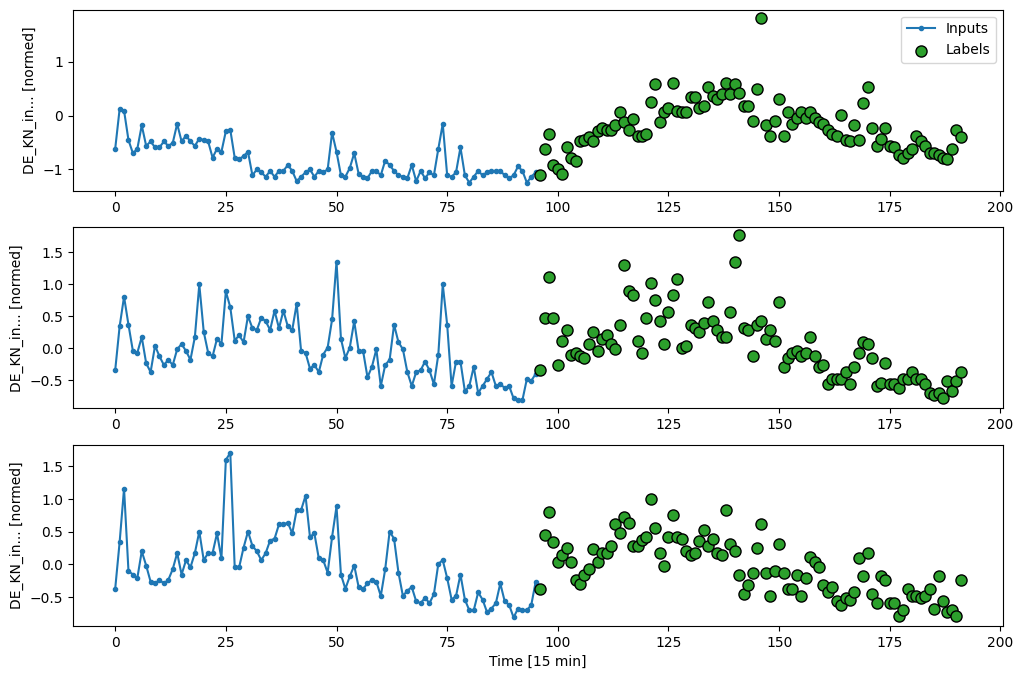

In [23]:
example_window_generator._example = example_inputs, example_labels
example_window_generator.plot(plot_col=f"{data_column_industrial}_instantaneous")

In [24]:
# Each element is an (inputs, label) pair.
example_window_generator.train.element_spec

(TensorSpec(shape=(None, 96, 7), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 96, 1), dtype=tf.float32, name=None))

The `batch size` in this case is None because to obtain an actual batch, we need to iterate over the `tensorflow.data.Dataset` object (i.e., the one returned by `train`).

In [25]:
for example_inputs, example_labels in example_window_generator.train.take(1):
    print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
    print(f"Labels shape (batch, time, features): {example_labels.shape}")

Inputs shape (batch, time, features): (32, 96, 7)
Labels shape (batch, time, features): (32, 96, 1)


2024-04-22 09:42:23.445236: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### <a id='toc1_1_4_'></a>[Training](#toc0_)

#### <a id='toc1_1_4_1_'></a>[Single Step Models](#toc0_)

Single step models make predictions for one future time step, given only the current conditions (one present time step).

In [27]:
single_step_window_industrial = WindowGenerator(
    input_width=1,
    label_width=1,
    shift=1,
    label_columns=[f"{data_column_industrial}_instantaneous"],
    train_df=train_df_industrial,
    val_df=val_df_industrial,
    test_df=test_df_industrial,
)

single_step_window_residential = WindowGenerator(
    input_width=1,
    label_width=1,
    shift=1,
    label_columns=[f"{data_column_residential}_instantaneous"],
    train_df=train_df_residential,
    val_df=val_df_residential,
    test_df=test_df_residential,
)

single_step_window_school = WindowGenerator(
    input_width=1,
    label_width=1,
    shift=1,
    label_columns=[f"{data_column_school}_instantaneous"],
    train_df=train_df_school,
    val_df=val_df_school,
    test_df=test_df_school,
)

print(single_step_window_industrial)
print(single_step_window_residential)
print(single_step_window_school)

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['DE_KN_industrial1_grid_import_instantaneous']
Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['DE_KN_residential1_grid_import_instantaneous']
Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['DE_KN_public1_grid_import_instantaneous']


In [28]:
for example_inputs, example_labels in single_step_window_industrial.train.take(1):
    print("Industrial Dataset")
    print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
    print(f"Labels shape (batch, time, features): {example_labels.shape}")
    print("----------------------------------------------------------------")

for example_inputs, example_labels in single_step_window_residential.train.take(1):
    print("Residential Dataset")
    print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
    print(f"Labels shape (batch, time, features): {example_labels.shape}")
    print("----------------------------------------------------------------")

for example_inputs, example_labels in single_step_window_school.train.take(1):
    print("School Dataset")
    print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
    print(f"Labels shape (batch, time, features): {example_labels.shape}")
    print("----------------------------------------------------------------")

Industrial Dataset
Inputs shape (batch, time, features): (32, 1, 7)
Labels shape (batch, time, features): (32, 1, 1)
----------------------------------------------------------------
Residential Dataset
Inputs shape (batch, time, features): (32, 1, 7)
Labels shape (batch, time, features): (32, 1, 1)
----------------------------------------------------------------


2024-04-22 09:42:23.696241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-22 09:42:23.847974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


School Dataset
Inputs shape (batch, time, features): (32, 1, 7)
Labels shape (batch, time, features): (32, 1, 1)
----------------------------------------------------------------


2024-04-22 09:42:23.964881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


The data shown above represents a batch, whose shape is specified during the creation of the `WindowGenerator` object, for each of the three training datasets.

We also create a `wide_window`, which has the same characteristics as the `single_time_step`, i.e., for each input time step, there is one label time step and a prediction to be made one time step into the future (`shift = 1`). However, this is repeated for multiple pairs of labels and inputs, in this case for 12 hours of data (`input_width = 48` and `label_width = 48`).

In [29]:
wide_window_industrial = WindowGenerator(
    input_width=4,
    label_width=4,
    shift=1,
    label_columns=[f"{data_column_industrial}_instantaneous"],
    train_df=train_df_industrial,
    val_df=val_df_industrial,
    test_df=test_df_industrial,
)

wide_window_residential = WindowGenerator(
    input_width=4,
    label_width=4,
    shift=1,
    label_columns=[f"{data_column_residential}_instantaneous"],
    train_df=train_df_residential,
    val_df=val_df_residential,
    test_df=test_df_residential,
)

wide_window_school = WindowGenerator(
    input_width=4,
    label_width=4,
    shift=1,
    label_columns=[f"{data_column_school}_instantaneous"],
    train_df=train_df_school,
    val_df=val_df_school,
    test_df=test_df_school,
)

print(wide_window_industrial)
print(wide_window_residential)
print(wide_window_school)

Total window size: 5
Input indices: [0 1 2 3]
Label indices: [1 2 3 4]
Label column name(s): ['DE_KN_industrial1_grid_import_instantaneous']
Total window size: 5
Input indices: [0 1 2 3]
Label indices: [1 2 3 4]
Label column name(s): ['DE_KN_residential1_grid_import_instantaneous']
Total window size: 5
Input indices: [0 1 2 3]
Label indices: [1 2 3 4]
Label column name(s): ['DE_KN_public1_grid_import_instantaneous']


##### <a id='toc1_1_4_1_1_'></a>[Linear Model](#toc0_)



In [30]:
linear_industrial = tf.keras.Sequential([tf.keras.layers.Dense(units=1)])

linear_residential = tf.keras.Sequential([tf.keras.layers.Dense(units=1)])

linear_school = tf.keras.Sequential([tf.keras.layers.Dense(units=1)])

print(
    "Input shape:", single_step_window_industrial.example[0].shape
)
print(
    "Output shape:", linear_industrial(single_step_window_industrial.example[0]).shape
)

Input shape: (32, 1, 7)
Output shape: (32, 1, 1)


Let's define a model compilation and fitting function that we will reuse for all models.

In [31]:
class R2Score(tf.keras.metrics.Metric):
    def __init__(self, name='r2_score', **kwargs):
        super(R2Score, self).__init__(name=name, **kwargs)
        self.total_r2_score = self.add_weight(name='total_r2_score', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.squeeze(y_true, axis=-1)
        y_pred = tf.squeeze(y_pred, axis=-1)
        total_r2_score = 1 - tf.reduce_sum(tf.square(y_true - y_pred)) / tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
        self.total_r2_score.assign_add(total_r2_score)
        self.count.assign_add(1)

    def result(self):
        return self.total_r2_score / self.count

    def reset_states(self):
        self.total_r2_score.assign(0)
        self.count.assign(0)


In [32]:
MAX_EPOCHS = 50


def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=patience, mode="min"
    )

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()],
    )

    history = model.fit(
        window.train,
        epochs=MAX_EPOCHS,
        validation_data=window.val,
        callbacks=[early_stopping],
    )
    return history

In [33]:
val_performance_industrial = {}
performance_industrial = {}

history_industrial = compile_and_fit(linear_industrial, single_step_window_industrial)

IPython.display.clear_output()
val_performance_industrial['Linear'] = linear_industrial.evaluate(single_step_window_industrial.val, return_dict=True)
performance_industrial['Linear'] = linear_industrial.evaluate(single_step_window_industrial.test, verbose=0, return_dict=True)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2095 - mean_absolute_error: 0.3433


In [34]:
val_performance_residential = {}
performance_residential = {}

history_residential = compile_and_fit(linear_residential, single_step_window_residential)

IPython.display.clear_output()
val_performance_residential['Linear'] = linear_residential.evaluate(single_step_window_residential.val, return_dict=True)
performance_residential['Linear'] = linear_residential.evaluate(single_step_window_residential.test, verbose=0, return_dict=True)

397/397 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5152 - mean_absolute_error: 0.3372


In [35]:
val_performance_school = {}
performance_school = {}

history_school = compile_and_fit(linear_school, single_step_window_school)

IPython.display.clear_output()
val_performance_school['Linear'] = linear_school.evaluate(single_step_window_school.val, return_dict=True)
performance_school['Linear'] = linear_school.evaluate(single_step_window_school.test, verbose=0, return_dict=True)

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2843 - mean_absolute_error: 0.2786


**Visualization of Results**

With the trained models, we can visualize the results using the `plot` method of `WindowGenerator` on a wider window, `wide_window`, defined previously. This allows us to clearly assess the model's performance.

In [ ]:
print('Industrial Dataset')
print('Input shape:', wide_window_industrial.example[0].shape)
print('Output shape:', linear_industrial(wide_window_industrial.example[0]).shape)
print('-------------------------------------------------------------------------')

print('Residential Dataset')
print('Input shape:', wide_window_industrial.example[0].shape)
print('Output shape:', linear_industrial(wide_window_industrial.example[0]).shape)
print('-------------------------------------------------------------------------')

print('School Dataset')
print('Input shape:', wide_window_industrial.example[0].shape)
print('Output shape:', linear_industrial(wide_window_industrial.example[0]).shape)
print('-------------------------------------------------------------------------')

Industrial Dataset
Input shape: (32, 4, 7)
Output shape: (32, 4, 1)
-------------------------------------------------------------------------
Residential Dataset
Input shape: (32, 4, 7)
Output shape: (32, 4, 1)
-------------------------------------------------------------------------
School Dataset
Input shape: (32, 4, 7)
Output shape: (32, 4, 1)
-------------------------------------------------------------------------


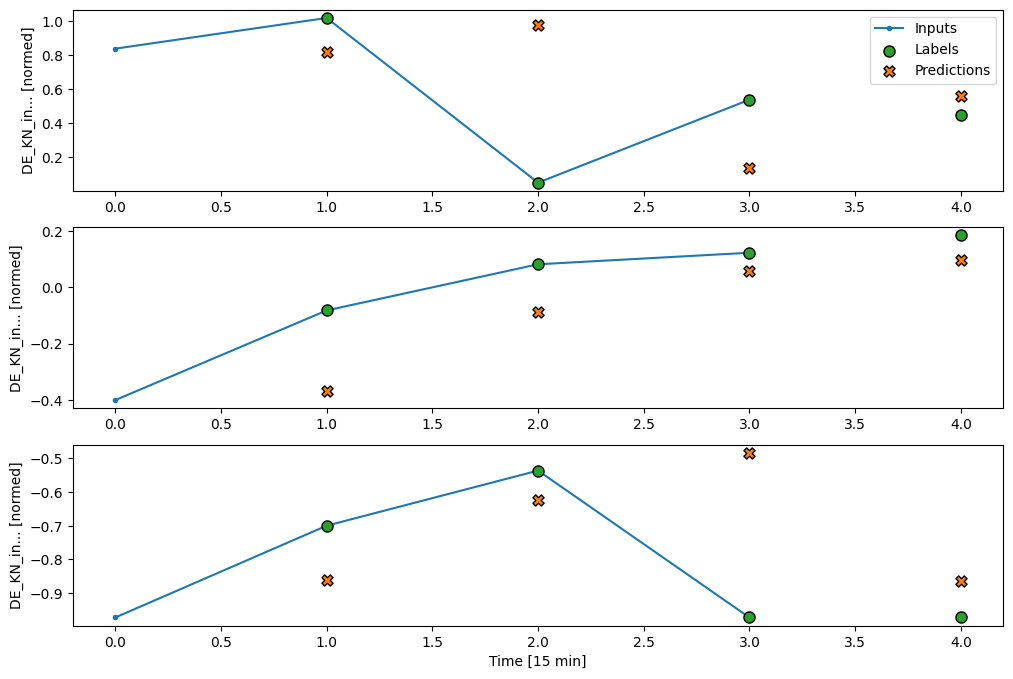

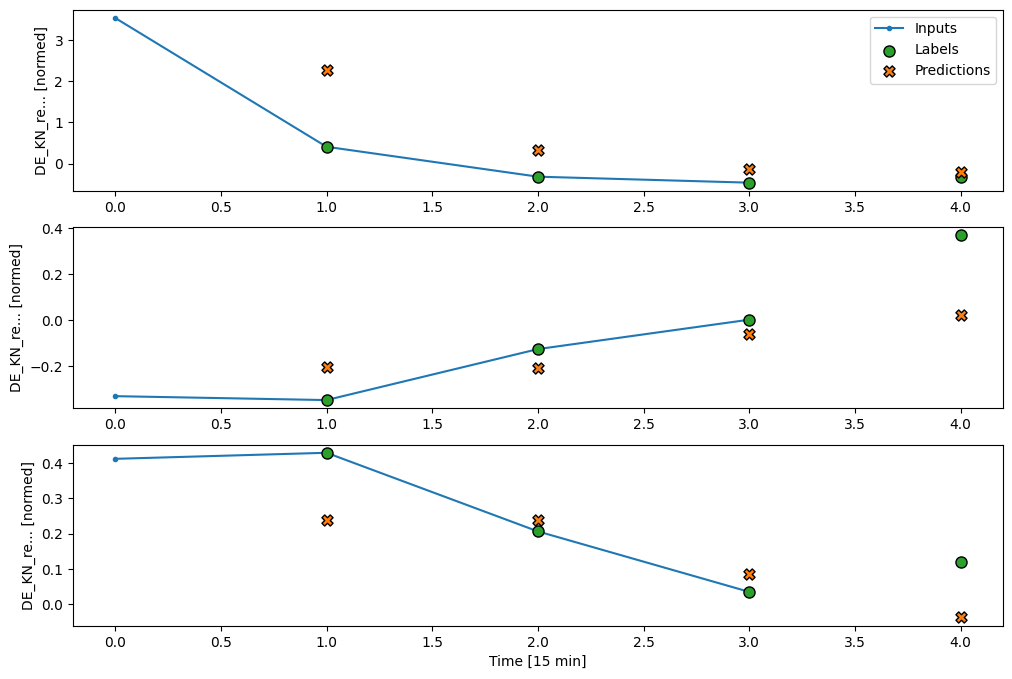

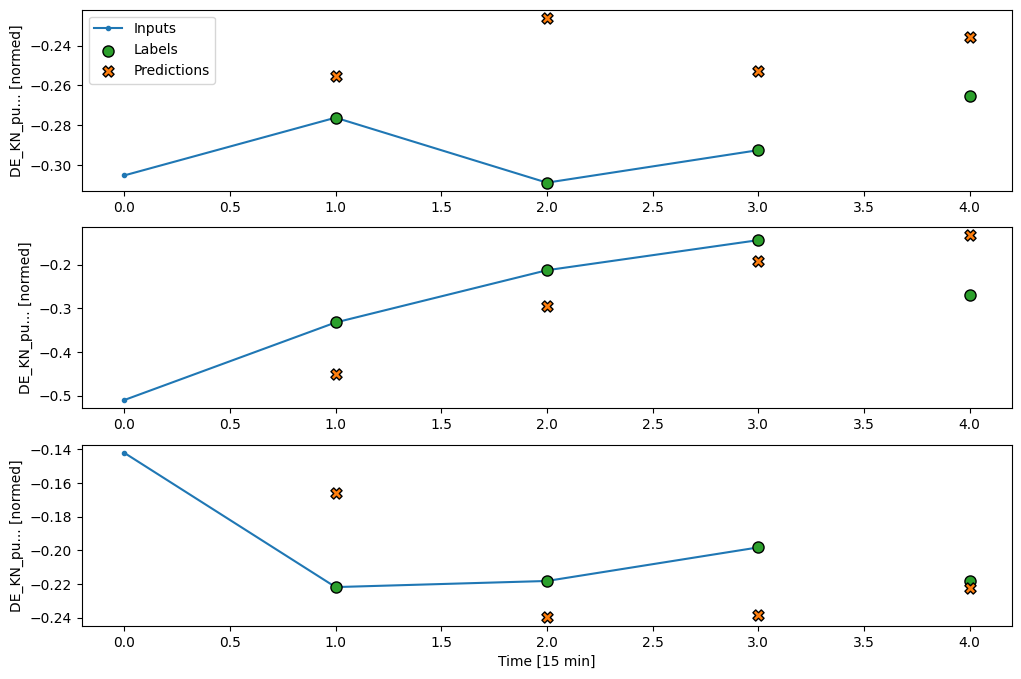

In [ ]:
wide_window_industrial.plot(plot_col=f'{data_column_industrial}_instantaneous', model=linear_industrial)

wide_window_residential.plot(plot_col=f'{data_column_residential}_instantaneous', model=linear_residential)

wide_window_school.plot(plot_col=f'{data_column_school}_instantaneous', model=linear_school)

With the linear models we can see the weights that the model has associated to each input.

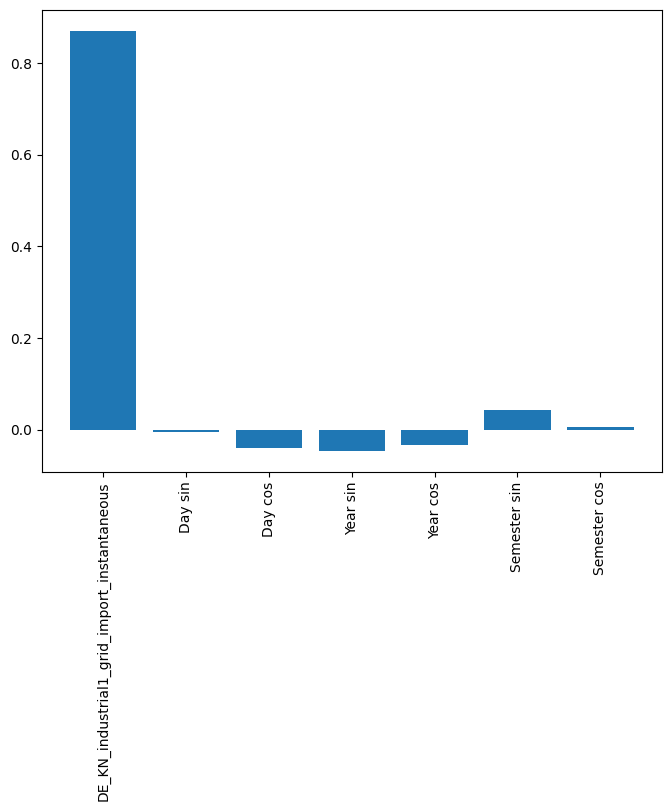

In [ ]:
plt.bar(x = range(len(train_df_industrial.columns)),
    height=linear_industrial.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df_industrial.columns)))
_ = axis.set_xticklabels(train_df_industrial.columns, rotation=90)

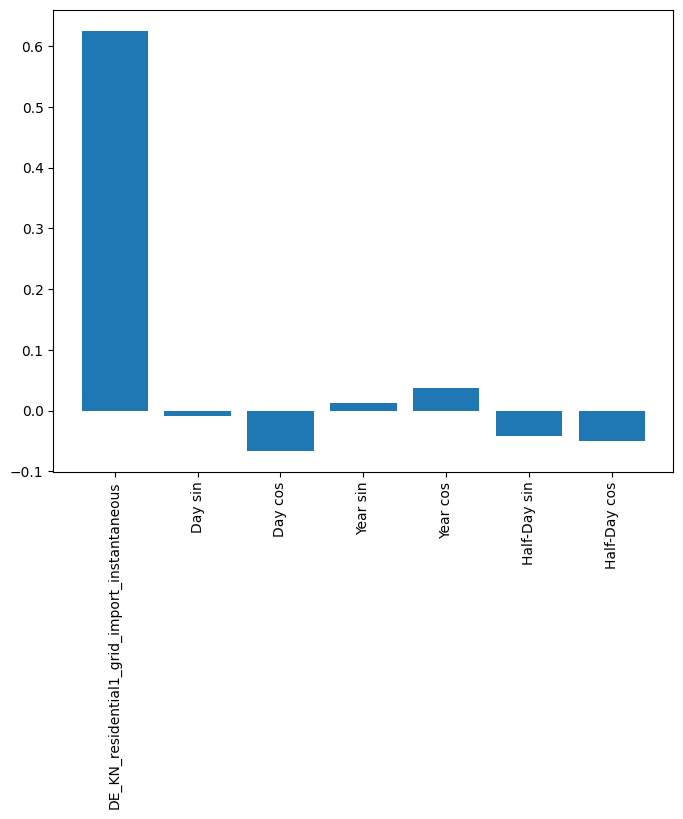

In [ ]:
plt.bar(x = range(len(train_df_residential.columns)),
    height=linear_residential.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df_residential.columns)))
_ = axis.set_xticklabels(train_df_residential.columns, rotation=90)

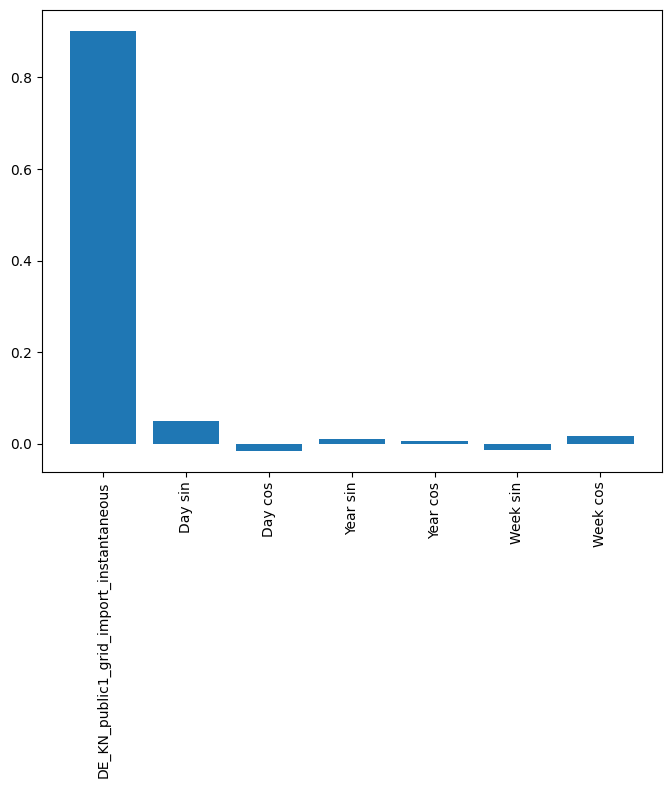

In [ ]:
plt.bar(x = range(len(train_df_school.columns)),
    height=linear_school.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df_school.columns)))
_ = axis.set_xticklabels(train_df_school.columns, rotation=90)

##### <a id='toc1_1_4_1_2_'></a>[Recurrent Neural Network](#toc0_)

A recurrent neural network (RNN) is a type of neural network suited for time series data. RNNs process a time series step-by-step, maintaining an internal state from one time step to another.

In [ ]:
lstm_model_industrial = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

lstm_model_residential = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

lstm_model_school = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Industrial Dataset')
print('Input shape:', wide_window_industrial.example[0].shape)
print('Output shape:', lstm_model_industrial(wide_window_industrial.example[0]).shape)
print('-------------------------------------------------------------------------')

print('Residential Dataset')
print('Input shape:', wide_window_residential.example[0].shape)
print('Output shape:', lstm_model_residential(wide_window_residential.example[0]).shape)
print('-------------------------------------------------------------------------')

print('School Dataset')
print('Input shape:', wide_window_school.example[0].shape)
print('Output shape:', lstm_model_school(wide_window_school.example[0]).shape)
print('-------------------------------------------------------------------------')

Industrial Dataset
Input shape: (32, 4, 7)
Output shape: (32, 4, 1)
-------------------------------------------------------------------------
Residential Dataset
Input shape: (32, 4, 7)
Output shape: (32, 4, 1)
-------------------------------------------------------------------------
School Dataset
Input shape: (32, 4, 7)
Output shape: (32, 4, 1)
-------------------------------------------------------------------------


In [ ]:
history_industrial = compile_and_fit(lstm_model_industrial, wide_window_industrial)

IPython.display.clear_output()
val_performance_industrial['LSTM'] = lstm_model_industrial.evaluate(wide_window_industrial.val, return_dict=True)
performance_industrial['LSTM'] = lstm_model_industrial.evaluate(wide_window_industrial.test, verbose=0, return_dict=True)

411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2415 - mean_absolute_error: 0.3715


In [ ]:
history_residential = compile_and_fit(lstm_model_residential, wide_window_residential)

IPython.display.clear_output()
val_performance_residential['LSTM'] = lstm_model_residential.evaluate(wide_window_residential.val, return_dict=True)
performance_residential['LSTM'] = lstm_model_residential.evaluate(wide_window_residential.test, verbose=0, return_dict=True)

397/397 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5138 - mean_absolute_error: 0.3426


In [ ]:
history_school = compile_and_fit(lstm_model_school, wide_window_school)

IPython.display.clear_output()
val_performance_school['LSTM'] = lstm_model_school.evaluate(wide_window_school.val, return_dict=True)
performance_school['LSTM'] = lstm_model_school.evaluate(wide_window_school.test, verbose=0, return_dict=True)

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2520 - mean_absolute_error: 0.2961


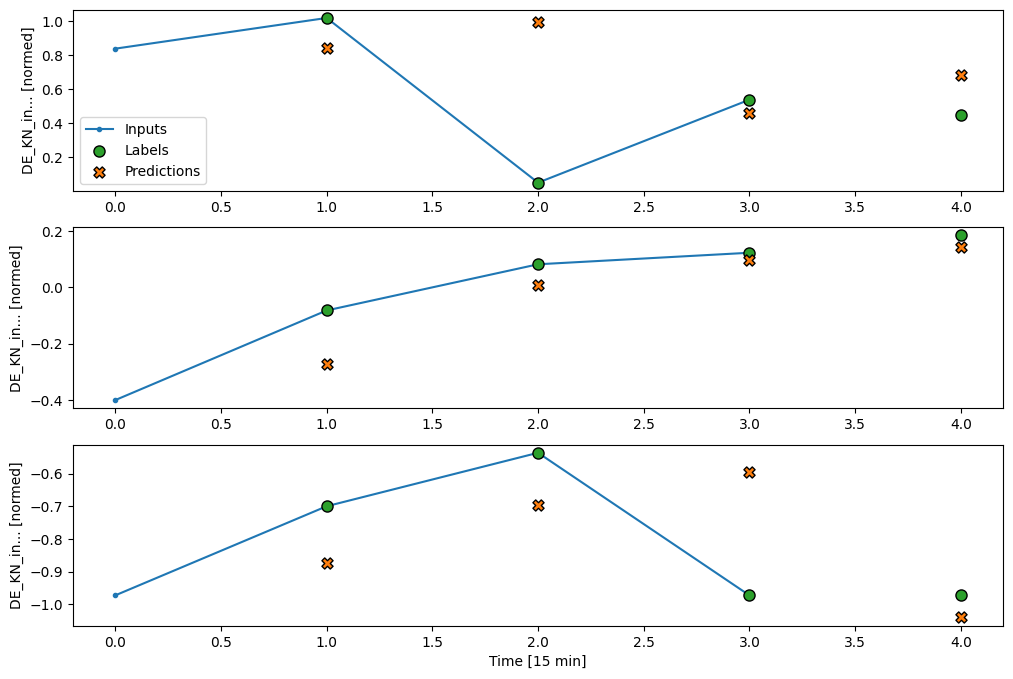

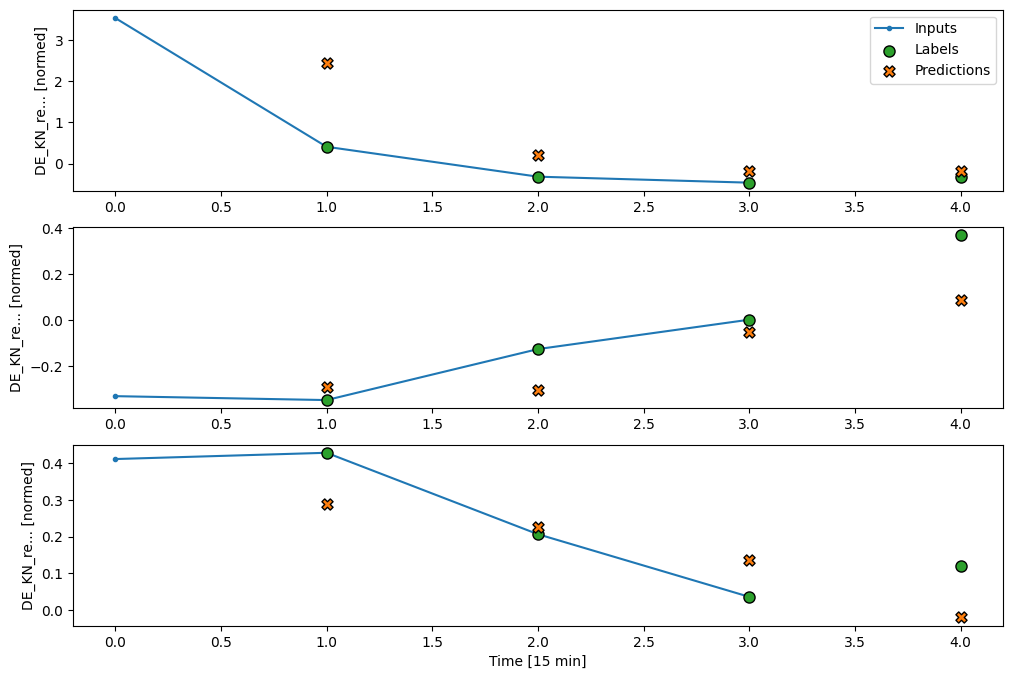

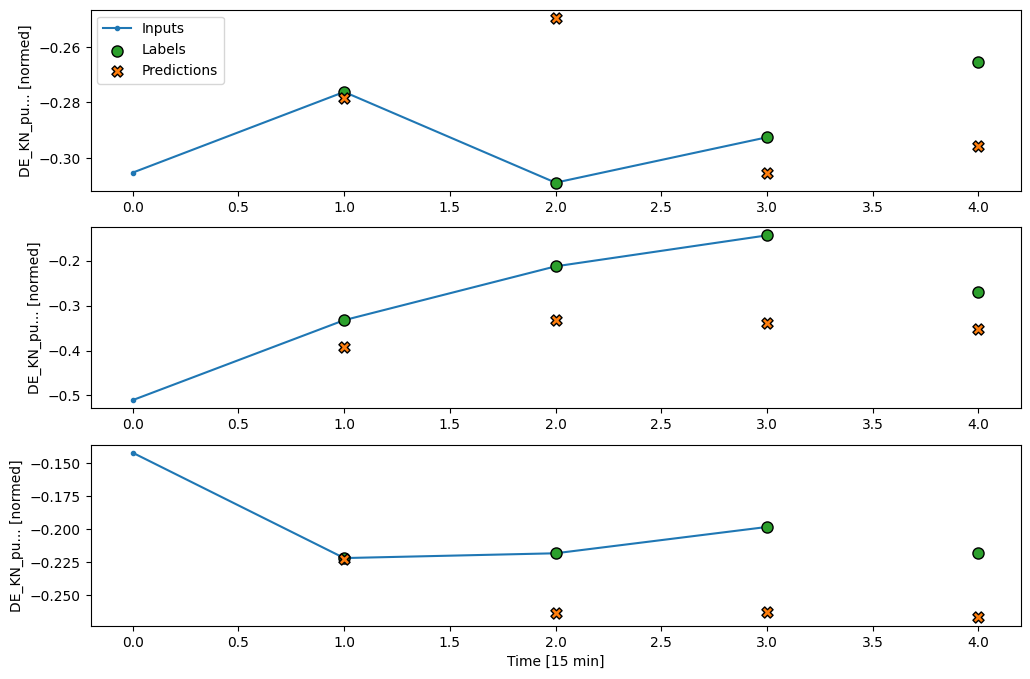

In [ ]:
wide_window_industrial.plot(plot_col=f'{data_column_industrial}_instantaneous', model=lstm_model_industrial)

wide_window_residential.plot(plot_col=f'{data_column_residential}_instantaneous', model=lstm_model_residential)

wide_window_school.plot(plot_col=f'{data_column_school}_instantaneous', model=lstm_model_school)

##### <a id='toc1_1_4_1_3_'></a>[Single step models performances](#toc0_)

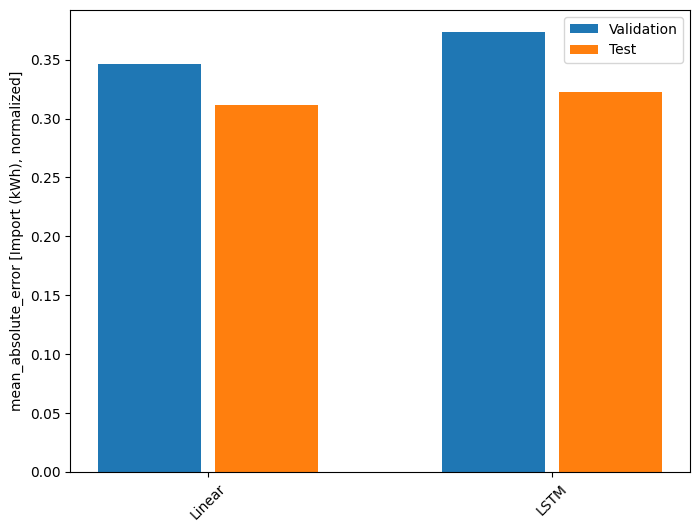

In [ ]:
x = np.arange(len(performance_industrial))
width = 0.3
metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance_industrial.values()]
test_mae = [v[metric_name] for v in performance_industrial.values()]

plt.ylabel('mean_absolute_error [Import (kWh), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance_industrial.keys(),
           rotation=45)
_ = plt.legend()

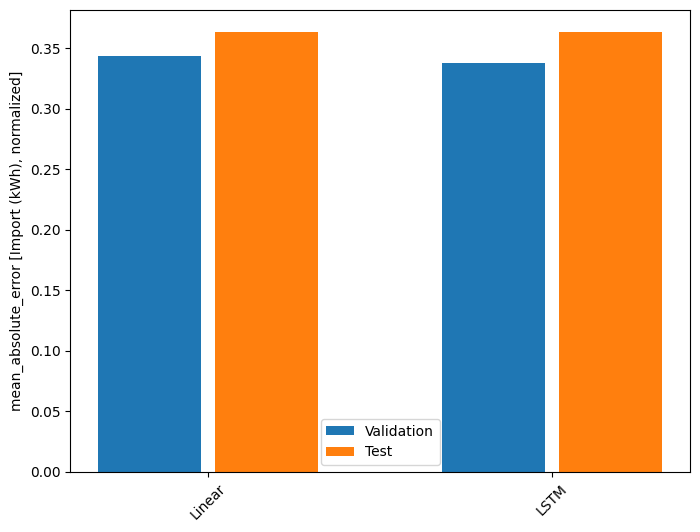

In [ ]:
x = np.arange(len(performance_residential))
width = 0.3
metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance_residential.values()]
test_mae = [v[metric_name] for v in performance_residential.values()]

plt.ylabel('mean_absolute_error [Import (kWh), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance_residential.keys(),
           rotation=45)
_ = plt.legend()

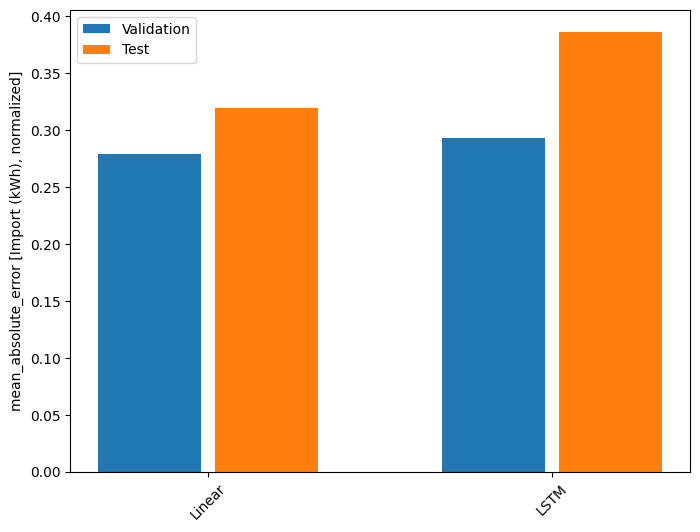

In [ ]:
x = np.arange(len(performance_school))
width = 0.3
metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance_school.values()]
test_mae = [v[metric_name] for v in performance_school.values()]

plt.ylabel('mean_absolute_error [Import (kWh), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance_school.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
print(f'Industrial Dataset - {metric_name}')
for name, value in performance_industrial.items():
  print(f'{name:8s}: {value[metric_name]:0.4f}')
print('-----------------------------------------')

print(f'Residential Dataset - {metric_name}')
for name, value in performance_residential.items():
  print(f'{name:8s}: {value[metric_name]:0.4f}')
print('-----------------------------------------')

print(f'School Dataset - {metric_name}')
for name, value in performance_school.items():
  print(f'{name:8s}: {value[metric_name]:0.4f}')
print('-----------------------------------------')

Industrial Dataset - mean_absolute_error
Linear  : 0.3119
LSTM    : 0.3222
-----------------------------------------
Residential Dataset - mean_absolute_error
Linear  : 0.3634
LSTM    : 0.3630
-----------------------------------------
School Dataset - mean_absolute_error
Linear  : 0.3195
LSTM    : 0.3864
-----------------------------------------


In conclusion, we observe that the performance difference between the linear model used as a baseline and the RNN is not significant, with the RNN even performing worse in some cases. It has also been noted that increasing the input window (previously set as `input width = 96*7`, corresponding to one week) further worsens the model's performance. This could be attributed to the fact that, for predicting energy consumption in the next 15 minutes, the most important data is likely the current or recent consumption. Therefore, providing a wider input window may deteriorate the prediction accuracy.

#### <a id='toc1_1_4_2_'></a>[Multi-Step Models](#toc0_)

Multi-step models make predictions for multiple timesteps into the future, given multiple timesteps of input data.

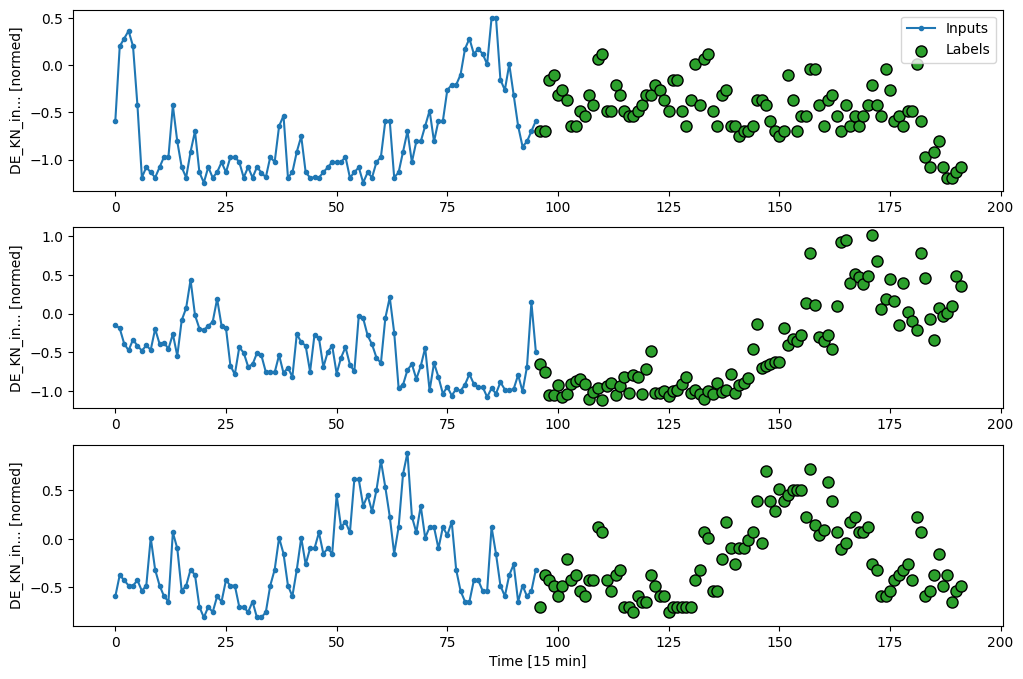

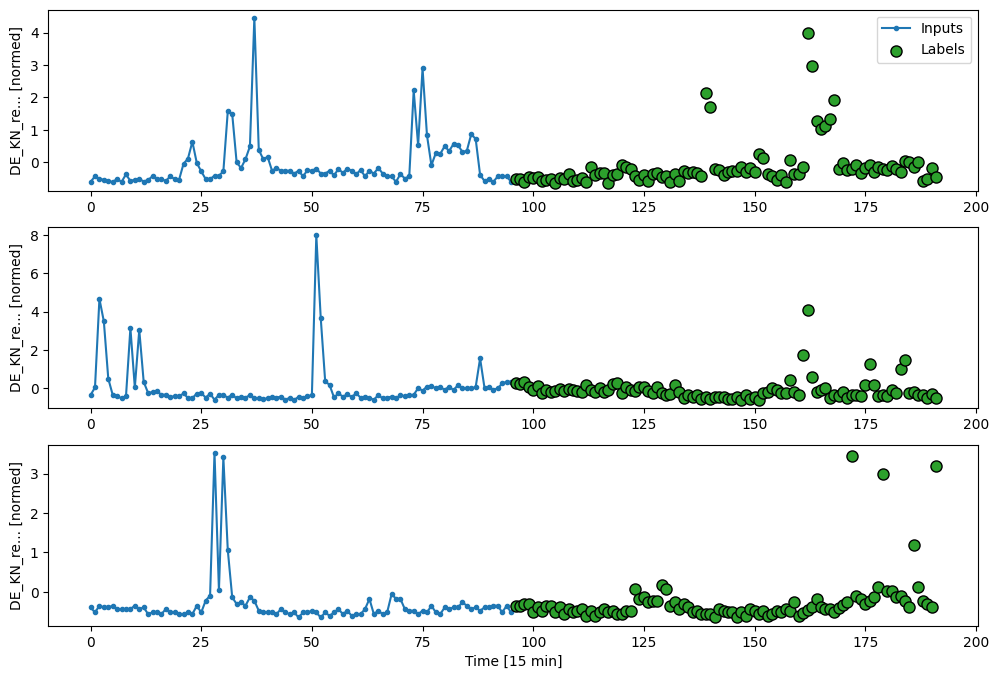

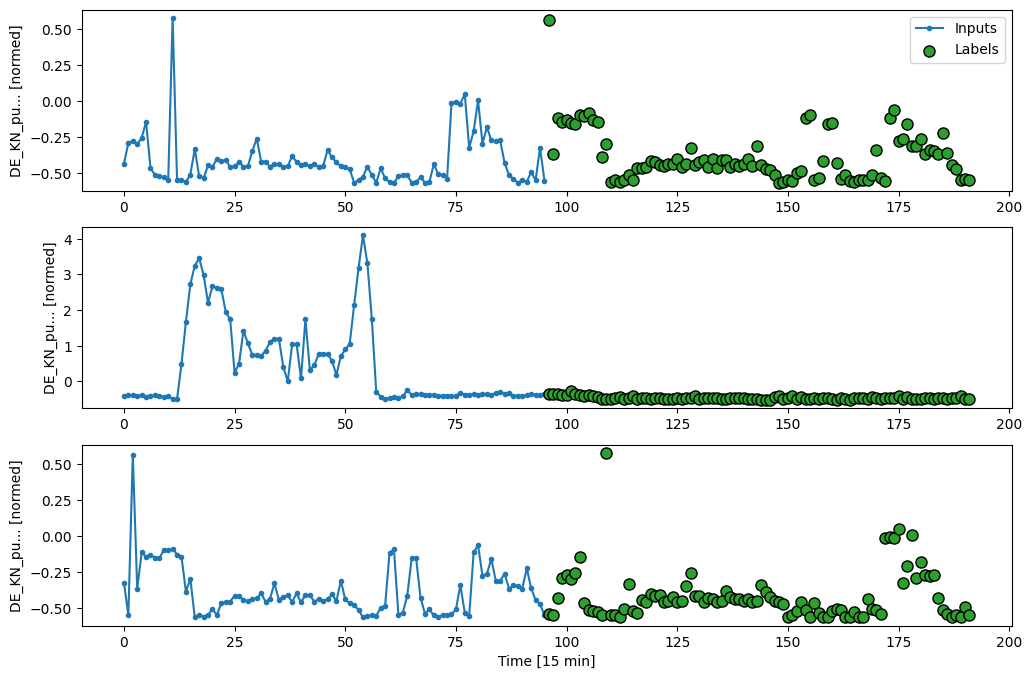

In [ ]:
OUT_STEPS = 96
multi_window_industrial = WindowGenerator(
    input_width=96,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    train_df=train_df_industrial,
    val_df=val_df_industrial,
    test_df=test_df_industrial,
)

multi_window_industrial.plot(plot_col=f"{data_column_industrial}_instantaneous")

multi_window_residential = WindowGenerator(
    input_width=96,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    train_df=train_df_residential,
    val_df=val_df_residential,
    test_df=test_df_residential,
)

multi_window_residential.plot(plot_col=f"{data_column_residential}_instantaneous")

multi_window_school = WindowGenerator(
    input_width=96,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    train_df=train_df_school,
    val_df=val_df_school,
    test_df=test_df_school,
)

multi_window_school.plot(plot_col=f"{data_column_school}_instantaneous")

##### <a id='toc1_1_4_2_1_'></a>[Linear Model](#toc0_)

In [ ]:
multi_val_performance_industrial = {}
multi_performance_industrial = {}

multi_val_performance_residential = {}
multi_performance_residential = {}

multi_val_performance_school = {}
multi_performance_school = {}

In [ ]:
multi_linear_model_industrial = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features_industrial,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features_industrial])
])

multi_linear_model_residential = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features_residential,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features_residential])
])

multi_linear_model_school = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features_school,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features_school])
])

In [ ]:
history = compile_and_fit(multi_linear_model_industrial, multi_window_industrial)

IPython.display.clear_output()
multi_val_performance_industrial['Linear'] = multi_linear_model_industrial.evaluate(multi_window_industrial.val, return_dict=True)
multi_performance_industrial['Linear'] = multi_linear_model_industrial.evaluate(multi_window_industrial.test, verbose=0, return_dict=True)

405/405 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1012 - mean_absolute_error: 0.0937


In [ ]:
history = compile_and_fit(multi_linear_model_residential, multi_window_residential)

IPython.display.clear_output()
multi_val_performance_residential['Linear'] = multi_linear_model_residential.evaluate(multi_window_residential.val, return_dict=True)
multi_performance_residential['Linear'] = multi_linear_model_residential.evaluate(multi_window_residential.test, verbose=0, return_dict=True)

391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1270 - mean_absolute_error: 0.0694


In [ ]:
history = compile_and_fit(multi_linear_model_school, multi_window_school)

IPython.display.clear_output()
multi_val_performance_school['Linear'] = multi_linear_model_school.evaluate(multi_window_school.val, return_dict=True)
multi_performance_school['Linear'] = multi_linear_model_school.evaluate(multi_window_school.test, verbose=0, return_dict=True)

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3634 - mean_absolute_error: 0.1355


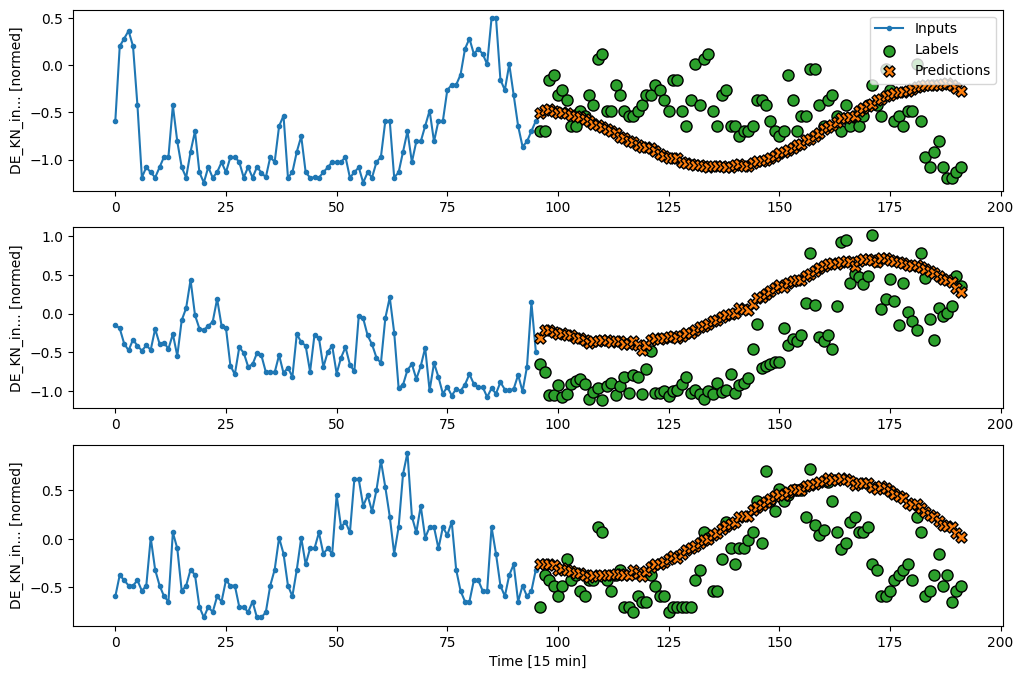

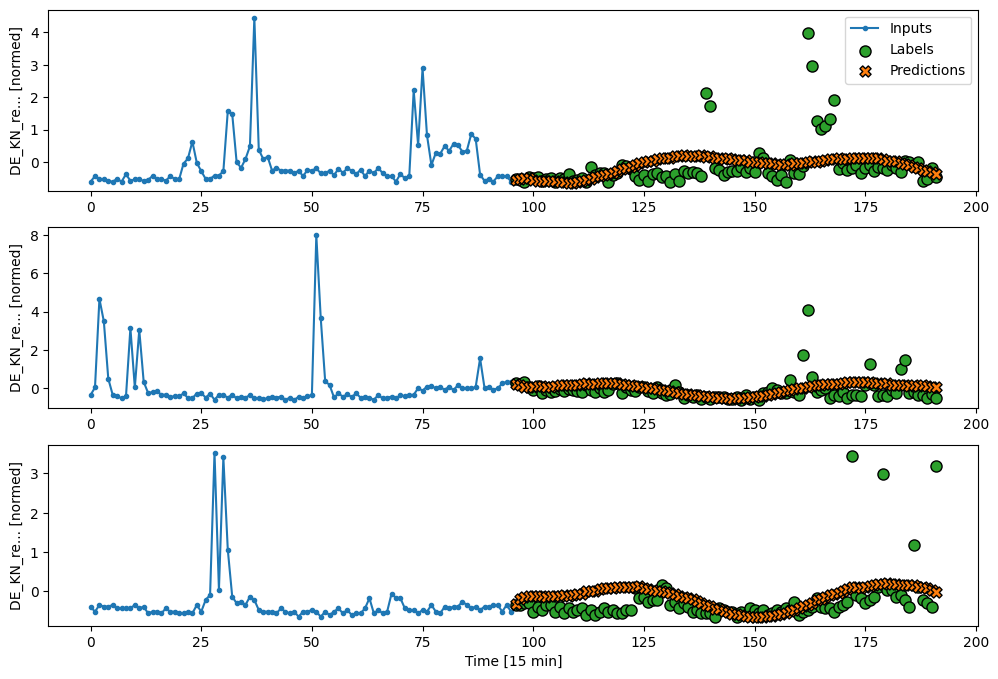

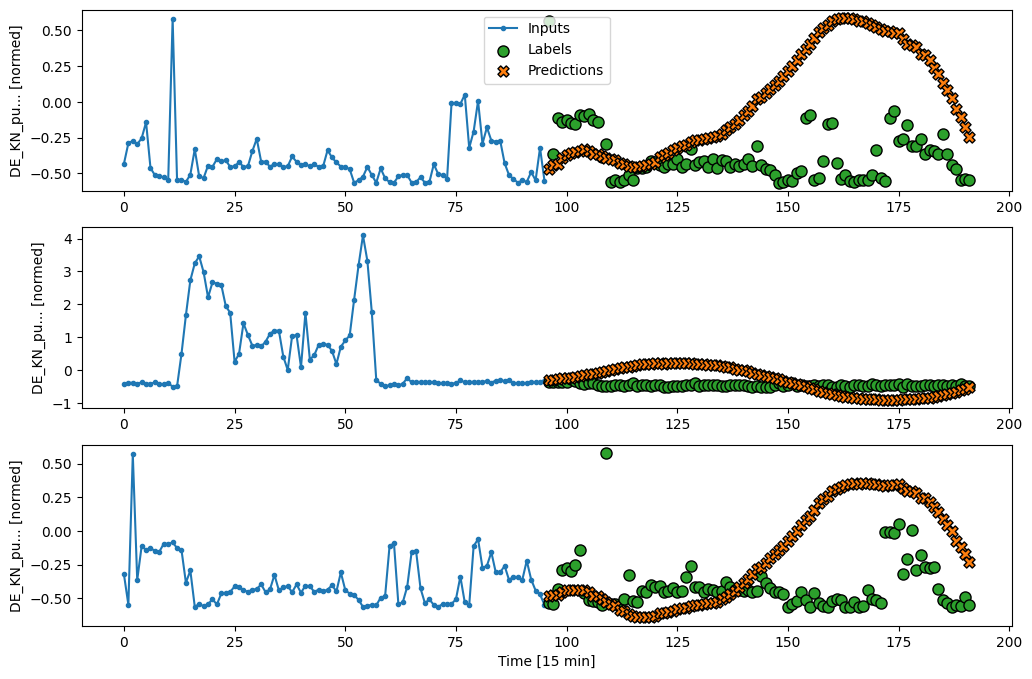

In [ ]:
multi_window_industrial.plot(plot_col=f'{data_column_industrial}_instantaneous', model=multi_linear_model_industrial)

multi_window_residential.plot(plot_col=f'{data_column_residential}_instantaneous', model=multi_linear_model_residential)

multi_window_school.plot(plot_col=f'{data_column_school}_instantaneous', model=multi_linear_model_school)

##### <a id='toc1_1_4_2_2_'></a>[Dense Model](#toc0_)

In [ ]:
multi_dense_model_industrial = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features_industrial,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features_industrial])
])

multi_dense_model_residential = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features_residential,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features_residential])
])


multi_dense_model_school = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features_school,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features_school])
])


In [ ]:
history = compile_and_fit(multi_dense_model_industrial, multi_window_industrial)

IPython.display.clear_output()
multi_val_performance_industrial['Dense'] = multi_dense_model_industrial.evaluate(multi_window_industrial.val, return_dict=True)
multi_performance_industrial['Dense'] = multi_dense_model_industrial.evaluate(multi_window_industrial.test, verbose=0, return_dict=True)

405/405 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1299 - mean_absolute_error: 0.1206


In [ ]:
history = compile_and_fit(multi_dense_model_residential, multi_window_residential)

IPython.display.clear_output()
multi_val_performance_residential['Dense'] = multi_dense_model_residential.evaluate(multi_window_residential.val, return_dict=True)
multi_performance_residential['Dense'] = multi_dense_model_residential.evaluate(multi_window_residential.test, verbose=0, return_dict=True)

391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1266 - mean_absolute_error: 0.0782


In [ ]:
history = compile_and_fit(multi_dense_model_school, multi_window_school)

IPython.display.clear_output()
multi_val_performance_school['Dense'] = multi_dense_model_school.evaluate(multi_window_school.val, return_dict=True)
multi_performance_school['Dense'] = multi_dense_model_school.evaluate(multi_window_school.test, verbose=0, return_dict=True)

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1958 - mean_absolute_error: 0.1649


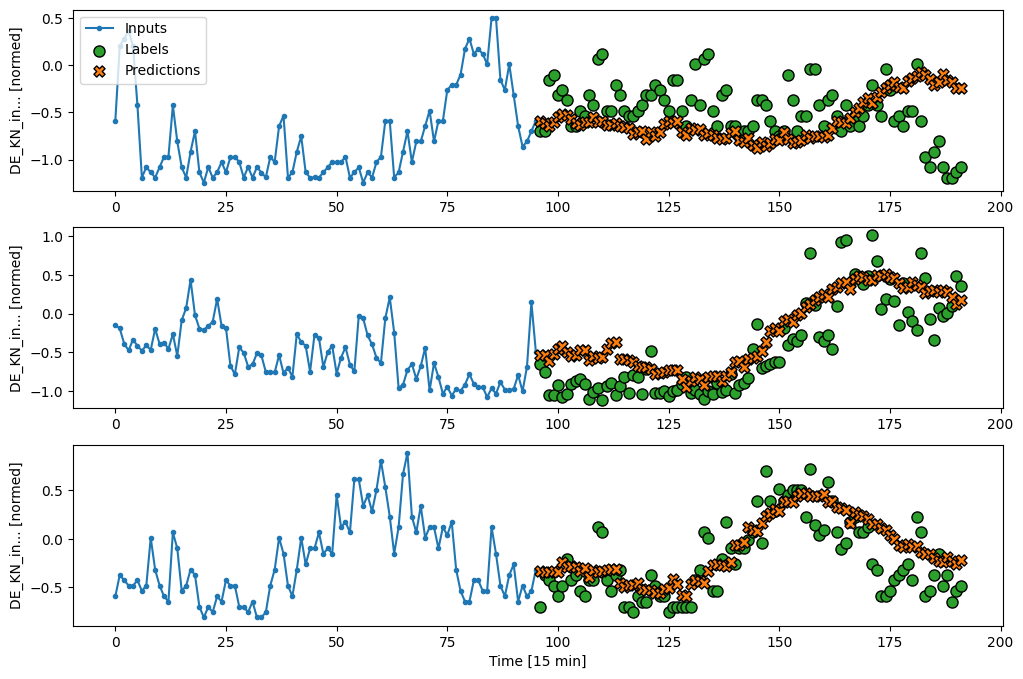

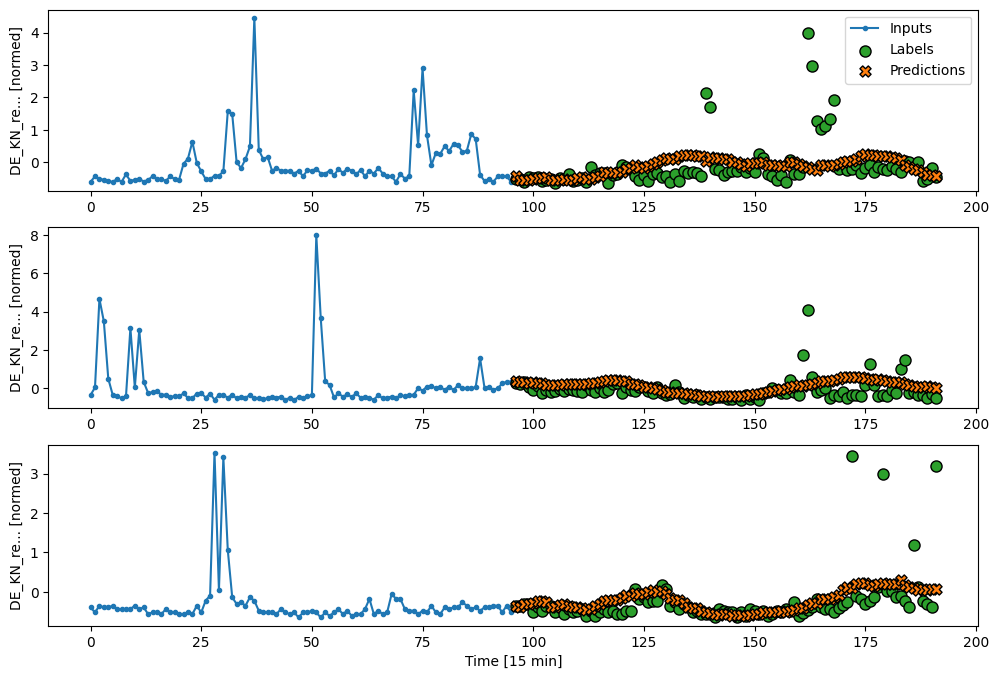

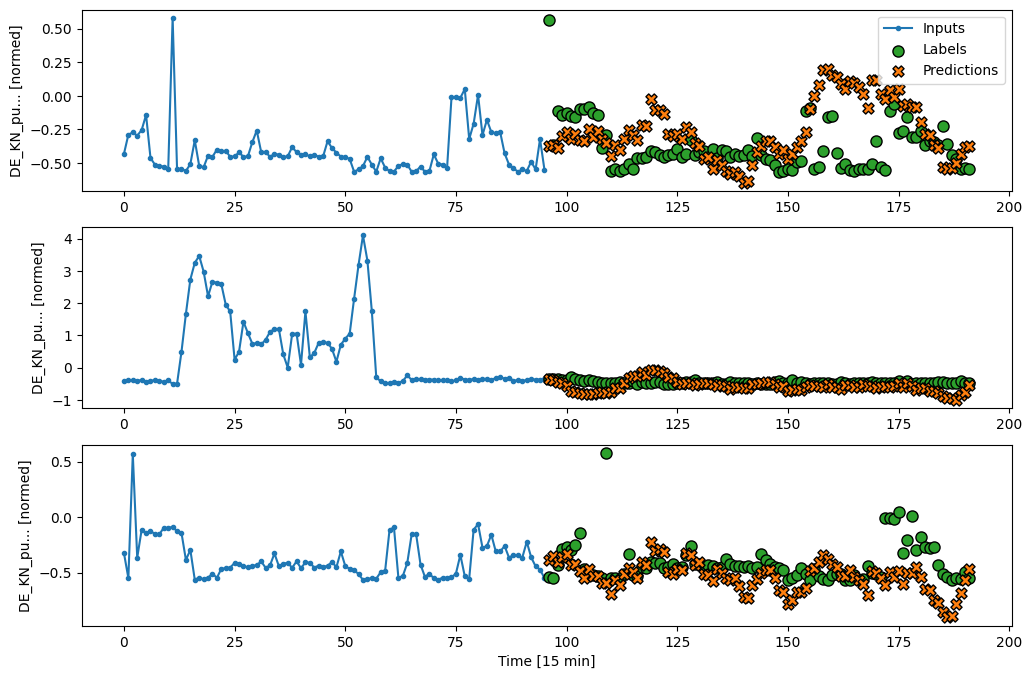

In [ ]:
multi_window_industrial.plot(plot_col=f'{data_column_industrial}_instantaneous', model=multi_dense_model_industrial)

multi_window_residential.plot(plot_col=f'{data_column_residential}_instantaneous', model=multi_dense_model_residential)

multi_window_school.plot(plot_col=f'{data_column_school}_instantaneous', model=multi_dense_model_school)

##### <a id='toc1_1_4_2_3_'></a>[CNN Model](#toc0_)

In [ ]:
CONV_WIDTH = 3
multi_conv_model_industrial = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features_industrial,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features_industrial])
])

multi_conv_model_residential = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features_residential,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features_residential])
])

multi_conv_model_school = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features_school,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features_school])
])


In [ ]:
history = compile_and_fit(multi_conv_model_industrial, multi_window_industrial)

IPython.display.clear_output()

multi_val_performance_industrial['Conv'] = multi_conv_model_industrial.evaluate(multi_window_industrial.val, return_dict=True)
multi_performance_industrial['Conv'] = multi_conv_model_industrial.evaluate(multi_window_industrial.test, verbose=0, return_dict=True)

405/405 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0962 - mean_absolute_error: 0.1043


In [ ]:
history = compile_and_fit(multi_conv_model_residential, multi_window_residential)

IPython.display.clear_output()

multi_val_performance_residential['Conv'] = multi_conv_model_residential.evaluate(multi_window_residential.val, return_dict=True)
multi_performance_residential['Conv'] = multi_conv_model_residential.evaluate(multi_window_residential.test, verbose=0, return_dict=True)

391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1257 - mean_absolute_error: 0.0790


In [ ]:
history = compile_and_fit(multi_conv_model_school, multi_window_school)

IPython.display.clear_output()

multi_val_performance_school['Conv'] = multi_conv_model_school.evaluate(multi_window_school.val, return_dict=True)
multi_performance_school['Conv'] = multi_conv_model_school.evaluate(multi_window_school.test, verbose=0, return_dict=True)

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1977 - mean_absolute_error: 0.1622


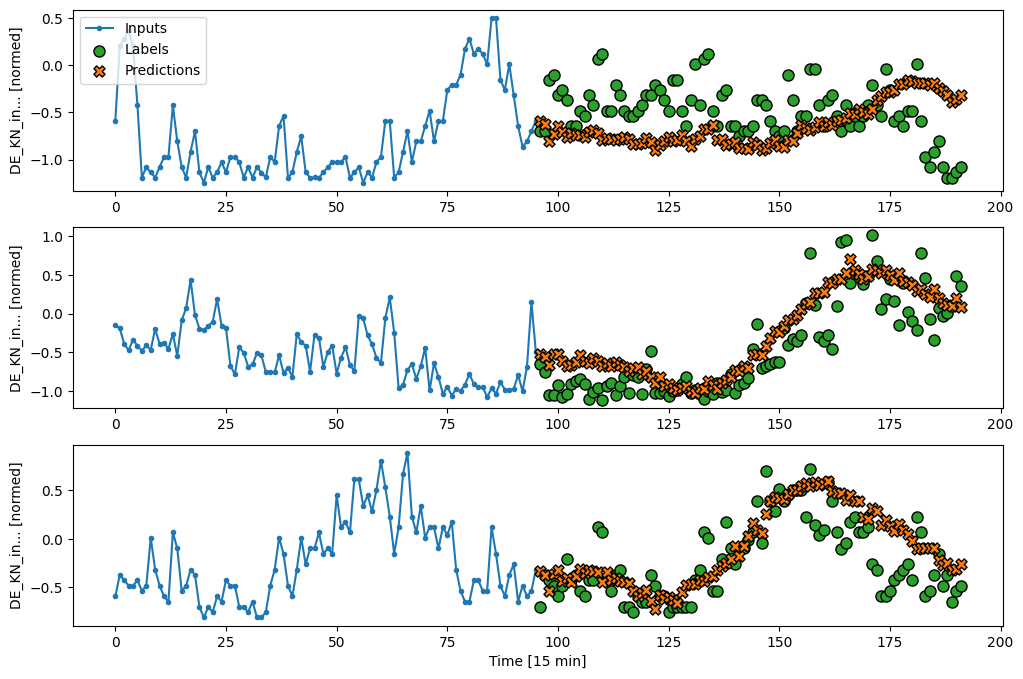

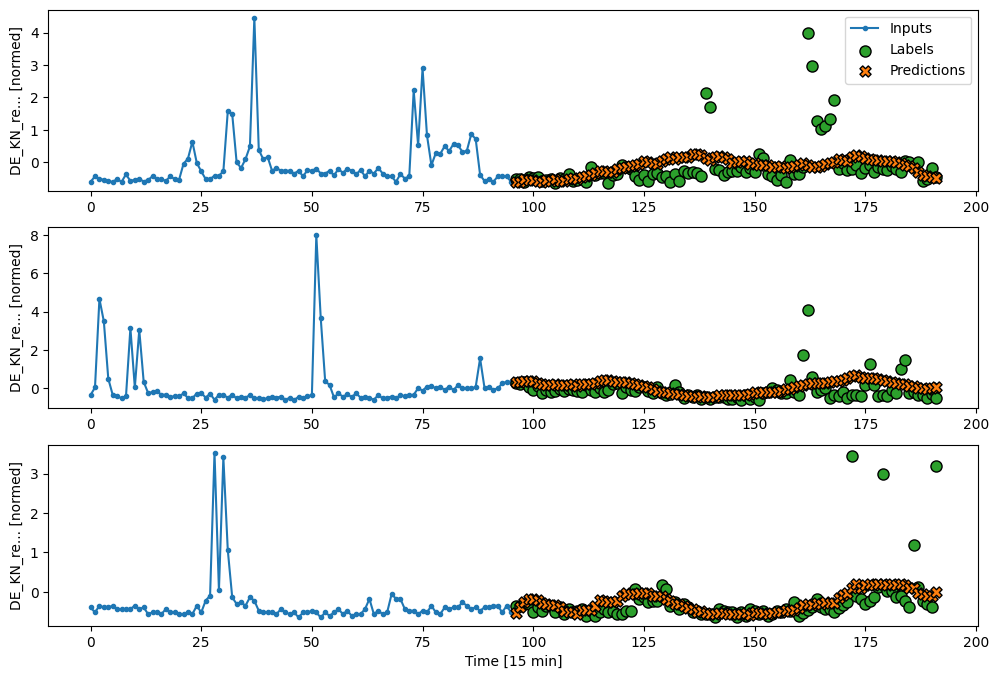

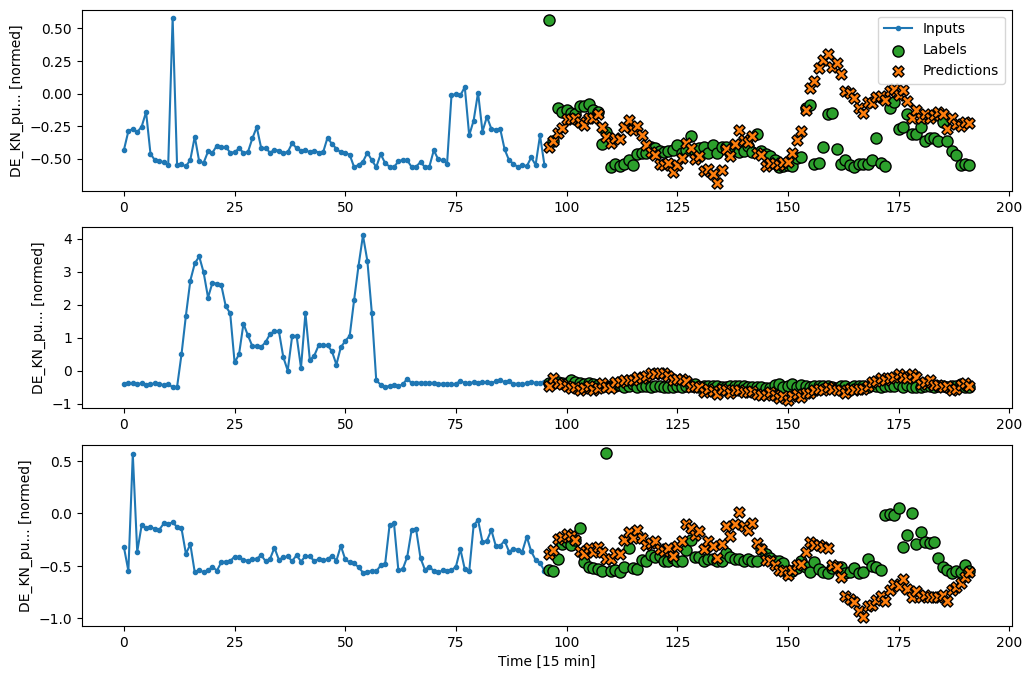

In [ ]:
multi_window_industrial.plot(plot_col=f'{data_column_industrial}_instantaneous', model=multi_conv_model_industrial)

multi_window_residential.plot(plot_col=f'{data_column_residential}_instantaneous', model=multi_conv_model_residential)

multi_window_school.plot(plot_col=f'{data_column_school}_instantaneous', model=multi_conv_model_school)

##### <a id='toc1_1_4_2_4_'></a>[RNN Model](#toc0_)

In [ ]:
multi_lstm_model_industrial = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features_industrial,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features_industrial])
])

multi_lstm_model_residential = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features_residential,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features_residential])
])

multi_lstm_model_school = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features_school,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features_school])
])

In [ ]:
history = compile_and_fit(multi_lstm_model_industrial, multi_window_industrial)

IPython.display.clear_output()
multi_val_performance_industrial['LSTM'] = multi_lstm_model_industrial.evaluate(multi_window_industrial.val, return_dict=True)
multi_performance_industrial['LSTM'] = multi_lstm_model_industrial.evaluate(multi_window_industrial.test, verbose=0, return_dict=True)

405/405 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.1490 - mean_absolute_error: 0.1637


In [ ]:
history = compile_and_fit(multi_lstm_model_residential, multi_window_residential)

IPython.display.clear_output()
multi_val_performance_residential['LSTM'] = multi_lstm_model_residential.evaluate(multi_window_residential.val, return_dict=True)
multi_performance_residential['LSTM'] = multi_lstm_model_residential.evaluate(multi_window_residential.test, verbose=0, return_dict=True)

391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.1280 - mean_absolute_error: 0.0819


In [ ]:
history = compile_and_fit(multi_lstm_model_school, multi_window_school)

IPython.display.clear_output()
multi_val_performance_school['LSTM'] = multi_lstm_model_school.evaluate(multi_window_school.val, return_dict=True)
multi_performance_school['LSTM'] = multi_lstm_model_school.evaluate(multi_window_school.test, verbose=0, return_dict=True)

108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.6023 - mean_absolute_error: 0.4043


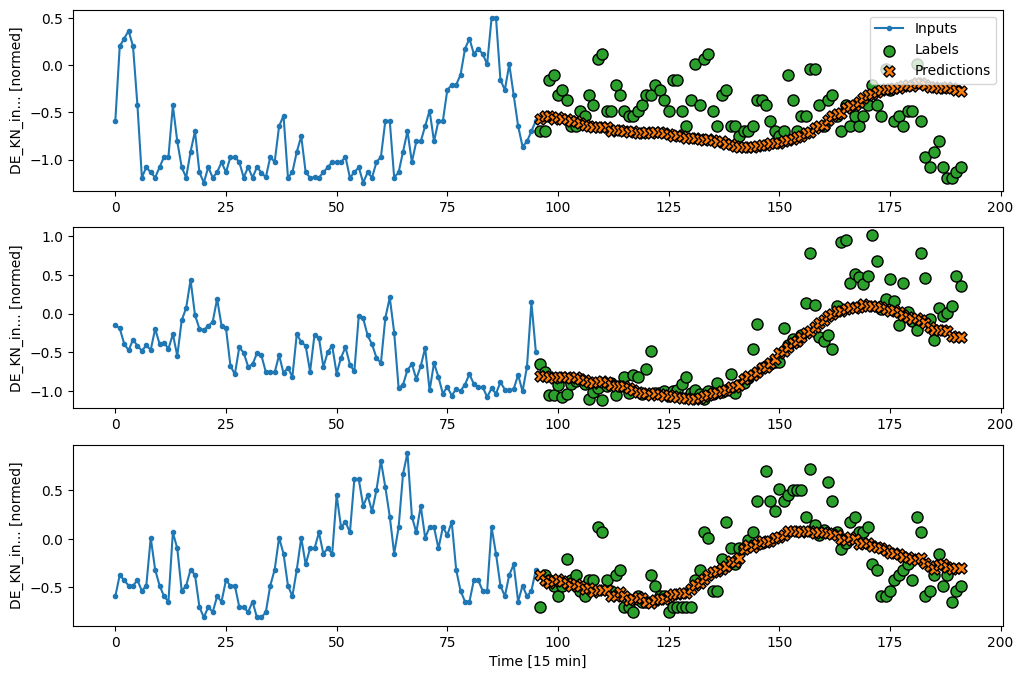

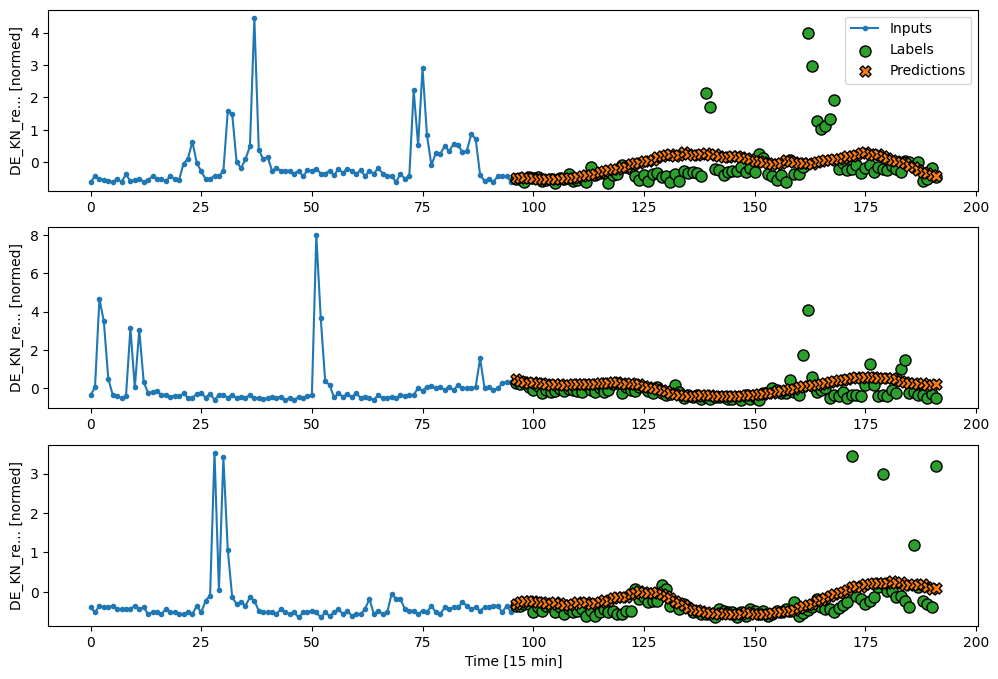

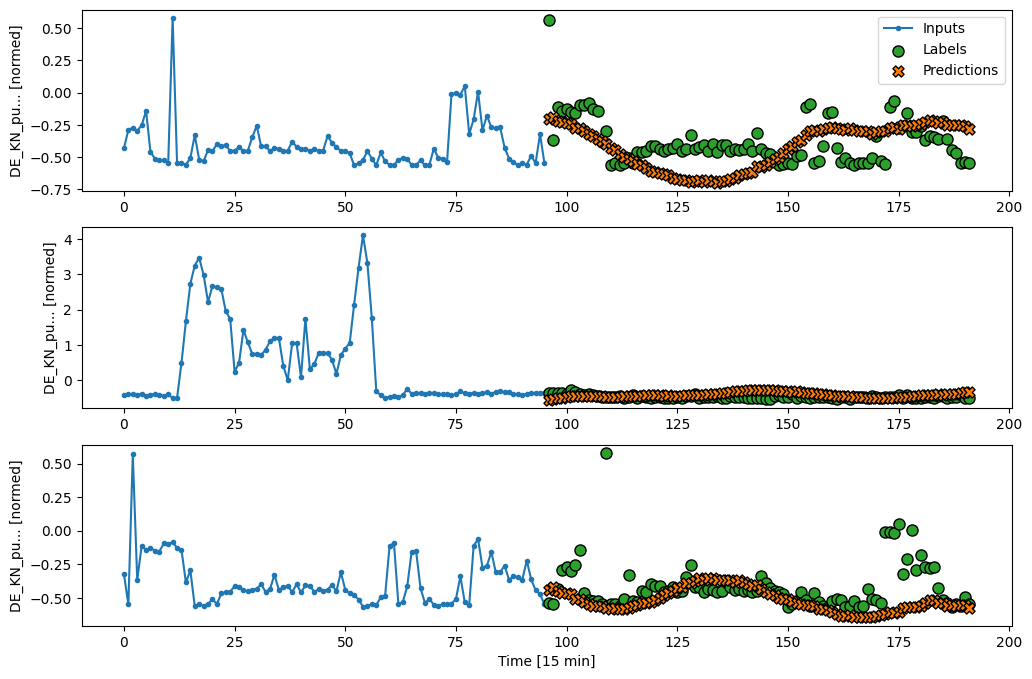

In [ ]:
multi_window_industrial.plot(plot_col=f'{data_column_industrial}_instantaneous', model=multi_lstm_model_industrial)

multi_window_residential.plot(plot_col=f'{data_column_residential}_instantaneous', model=multi_lstm_model_residential)

multi_window_school.plot(plot_col=f'{data_column_school}_instantaneous', model=multi_lstm_model_school)

##### <a id='toc1_1_4_2_5_'></a>[Autoregressive RNN Model](#toc0_)

In [ ]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps, num_features):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state
    
    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the LSTM state.
        prediction, state = self.warmup(inputs)

        # Insert the first prediction.
        predictions.append(prediction)

        # Run the rest of the prediction steps.
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                    training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output.
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions	

In [ ]:
feedback_model_industrial = FeedBack(units=32, out_steps=OUT_STEPS, num_features=num_features_industrial)

feedback_model_residential = FeedBack(units=32, out_steps=OUT_STEPS, num_features=num_features_residential)

feedback_model_school = FeedBack(units=32, out_steps=OUT_STEPS, num_features=num_features_school)

In [ ]:
prediction_industrial, state_industrial = feedback_model_industrial.warmup(multi_window_industrial.example[0])

prediction_residential, state_residential = feedback_model_residential.warmup(multi_window_residential.example[0])

prediction_school, state_school = feedback_model_school.warmup(multi_window_school.example[0])


print(prediction_industrial.shape)
print(prediction_residential.shape)
print(prediction_school.shape)

(32, 7)
(32, 7)
(32, 7)


In [ ]:
print('Output shape (batch, time, features): ', feedback_model_industrial(multi_window_industrial.example[0]).shape)

print('Output shape (batch, time, features): ', feedback_model_residential(multi_window_residential.example[0]).shape)

print('Output shape (batch, time, features): ', feedback_model_school(multi_window_school.example[0]).shape)

Output shape (batch, time, features):  (32, 96, 7)
Output shape (batch, time, features):  (32, 96, 7)
Output shape (batch, time, features):  (32, 96, 7)


In [ ]:
history = compile_and_fit(feedback_model_industrial, multi_window_industrial)

IPython.display.clear_output()

multi_val_performance_industrial['AR LSTM'] = feedback_model_industrial.evaluate(multi_window_industrial.val, return_dict=True)
multi_performance_industrial['AR LSTM'] = feedback_model_industrial.evaluate(multi_window_industrial.test, verbose=0, return_dict=True)

405/405 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - loss: 0.2839 - mean_absolute_error: 0.2650


In [ ]:
history = compile_and_fit(feedback_model_residential, multi_window_residential)

IPython.display.clear_output()

multi_val_performance_residential['AR LSTM'] = feedback_model_residential.evaluate(multi_window_residential.val, return_dict=True)
multi_performance_residential['AR LSTM'] = feedback_model_residential.evaluate(multi_window_residential.test, verbose=0, return_dict=True)

391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - loss: 0.1270 - mean_absolute_error: 0.0943


In [ ]:
history = compile_and_fit(feedback_model_school, multi_window_school)

IPython.display.clear_output()

multi_val_performance_school['AR LSTM'] = feedback_model_school.evaluate(multi_window_school.val, return_dict=True)
multi_performance_school['AR LSTM'] = feedback_model_school.evaluate(multi_window_school.test, verbose=0, return_dict=True)

108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.6208 - mean_absolute_error: 0.4602


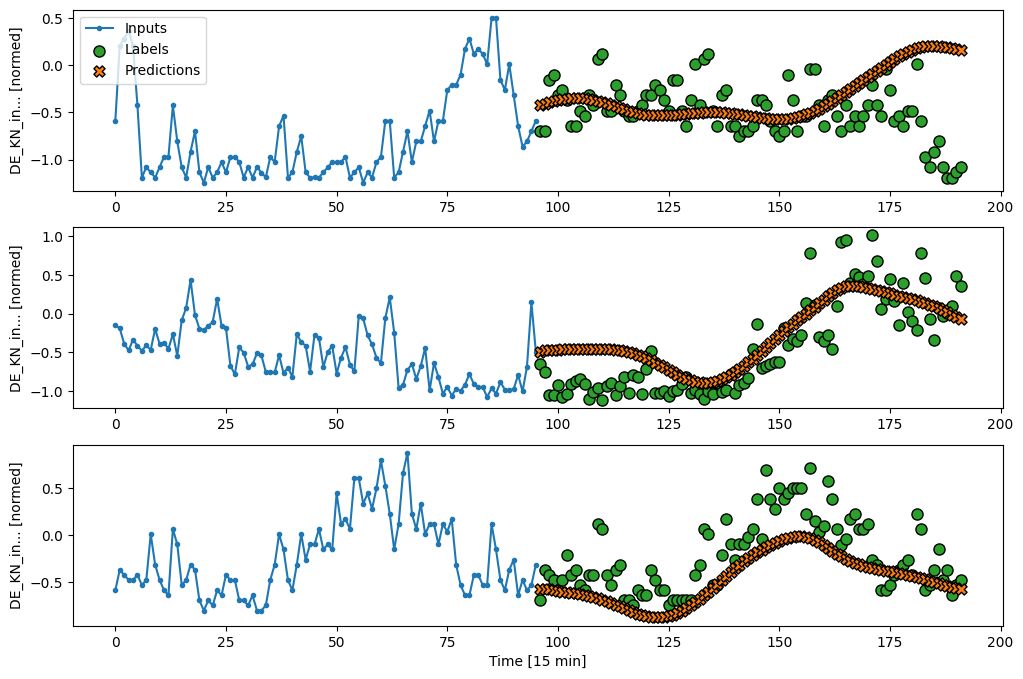

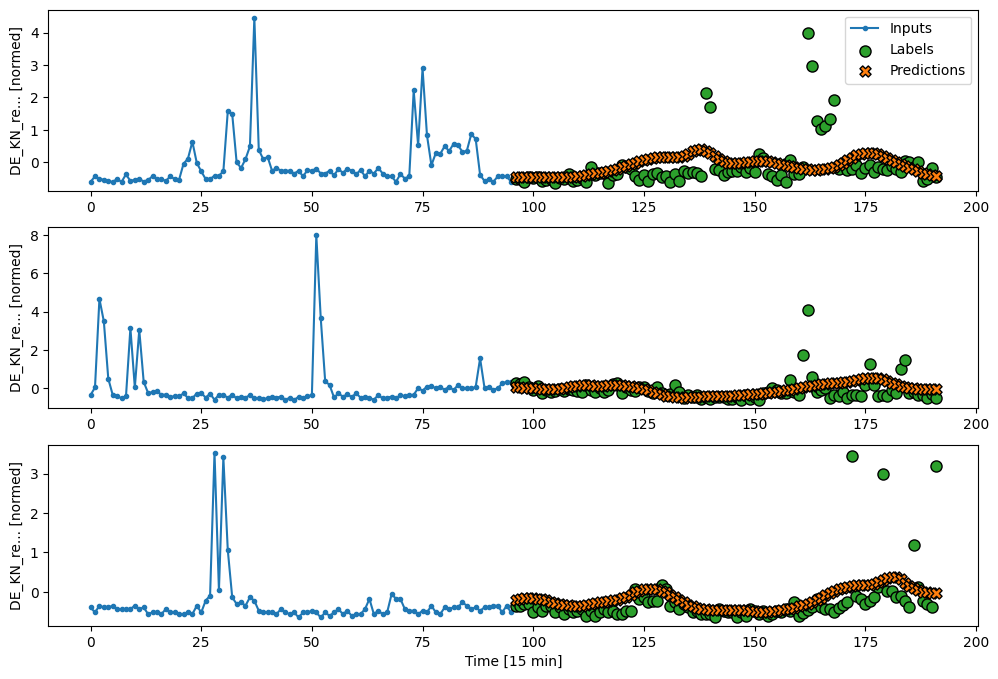

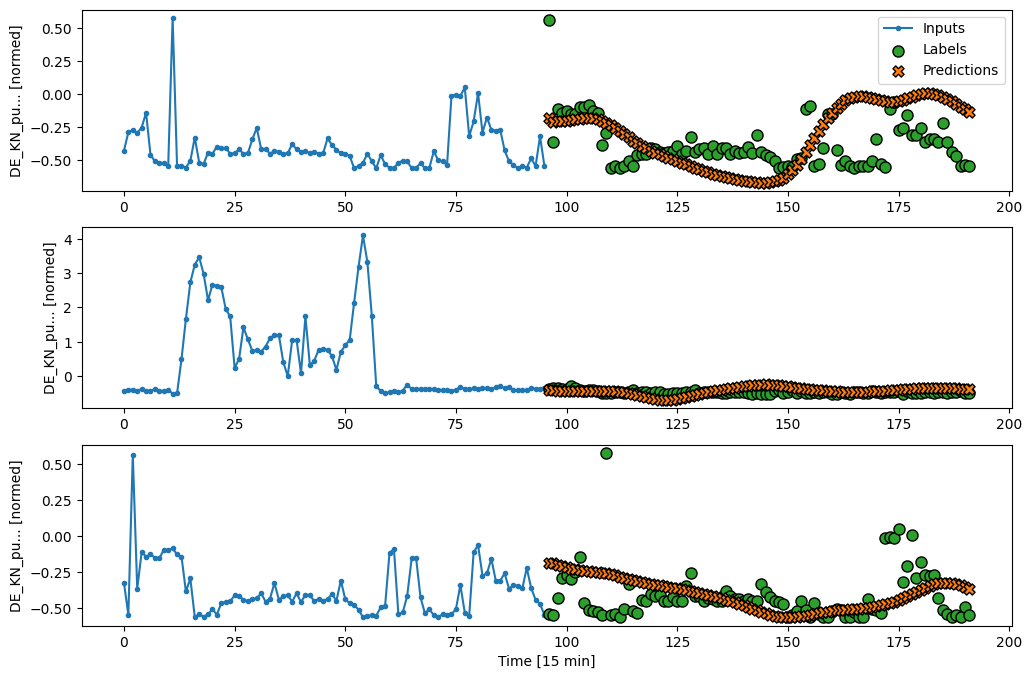

In [ ]:
multi_window_industrial.plot(plot_col=f'{data_column_industrial}_instantaneous', model=feedback_model_industrial)

multi_window_residential.plot(plot_col=f'{data_column_residential}_instantaneous', model=feedback_model_residential)

multi_window_school.plot(plot_col=f'{data_column_school}_instantaneous', model=feedback_model_school)

##### <a id='toc1_1_4_2_6_'></a>[Multi Step Models Performances](#toc0_)

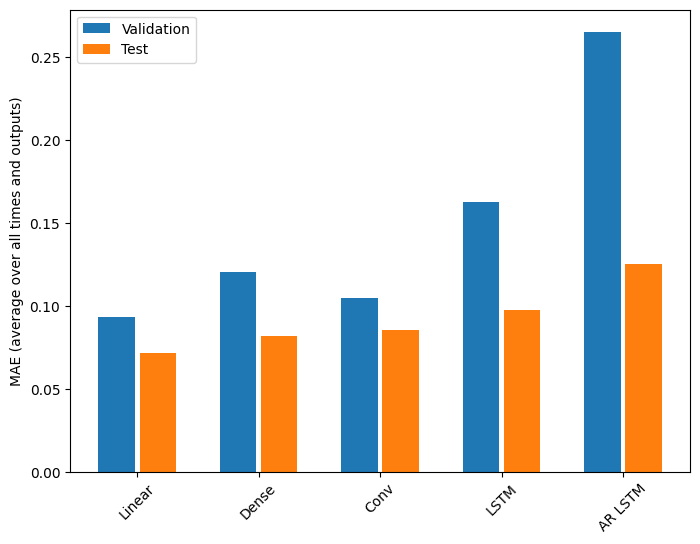

In [ ]:
x = np.arange(len(multi_performance_industrial))
width = 0.3

metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in multi_val_performance_industrial.values()]
test_mae = [v[metric_name] for v in multi_performance_industrial.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance_industrial.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

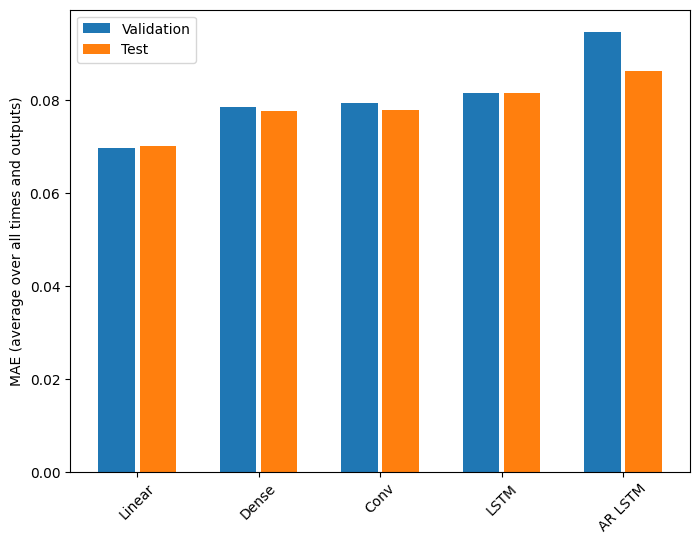

In [ ]:
x = np.arange(len(multi_performance_residential))
width = 0.3

metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in multi_val_performance_residential.values()]
test_mae = [v[metric_name] for v in multi_performance_residential.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance_residential.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

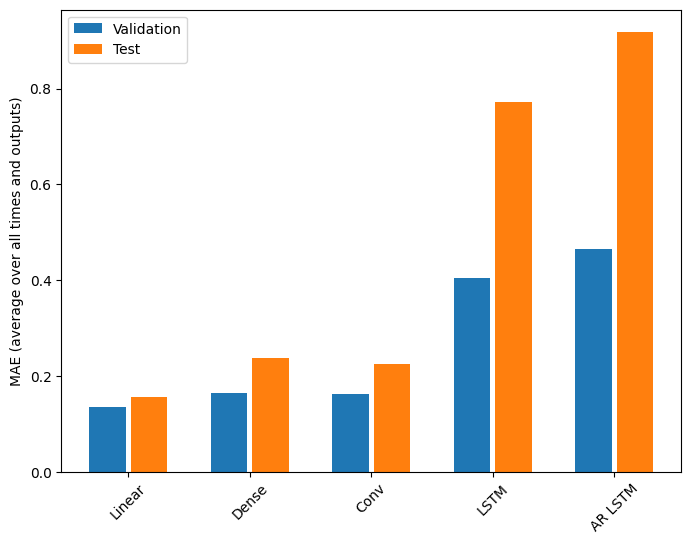

In [ ]:
x = np.arange(len(multi_performance_school))
width = 0.3

metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in multi_val_performance_school.values()]
test_mae = [v[metric_name] for v in multi_performance_school.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance_school.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [ ]:
print(f'Industrial Dataset - {metric_name}')
for name, value in multi_performance_industrial.items():
  print(f'{name:8s}: {value[metric_name]:0.4f}')
print('-----------------------------------------')

print(f'Residential Dataset - {metric_name}')
for name, value in multi_performance_residential.items():
  print(f'{name:8s}: {value[metric_name]:0.4f}')
print('-----------------------------------------')

print(f'School Dataset - {metric_name}')
for name, value in multi_performance_school.items():
  print(f'{name:8s}: {value[metric_name]:0.4f}')
print('-----------------------------------------')

Industrial Dataset - mean_absolute_error
Linear  : 0.0716
Dense   : 0.0817
Conv    : 0.0855
LSTM    : 0.0976
AR LSTM : 0.1254
-----------------------------------------
Residential Dataset - mean_absolute_error
Linear  : 0.0701
Dense   : 0.0776
Conv    : 0.0778
LSTM    : 0.0814
AR LSTM : 0.0862
-----------------------------------------
School Dataset - mean_absolute_error
Linear  : 0.1554
Dense   : 0.2380
Conv    : 0.2249
LSTM    : 0.7716
AR LSTM : 0.9190
-----------------------------------------


### <a id='toc1_1_5_'></a>[Chosen Approach for Frequencies](#toc0_)

Training was conducted both with the automatic selection of frequencies and with the interpretation of results to determine the best frequencies. The training sessions conducted above used the interpretative approach, as it generally yielded better results compared to the automatic approach. Below are the results for both cases, along with two illustrative images showing the difference between the two approaches.

**Interpretative Approach**

| Dataset     | Linear  | Dense   | Conv    | AR LSTM |
|-------------|---------|---------|---------|---------|
| Industrial  | 0.0719  | 0.0779  | 0.0862  | 0.1337  |
| Residential | 0.0696  | 0.0776  | 0.0854  | 0.0941  |
| School      | 0.1564  | 0.1970  | 0.1985  | 0.8292`*` |

`*` The interpretative approach is always better except in one case.

**Automatic Approach**

| Dataset     | Linear  | Dense   | Conv    | AR LSTM |
|-------------|---------|---------|---------|---------|
| Industrial  | 0.0854  | 0.1001  | 0.0964  | 0.1474  |
| Residential | 0.0708  | 0.0989  | 0.0991  | 0.2194  |
| School      | 0.1581  | 0.2499  | 0.2440  | 0.4942  |


![CNN Interpretativo](resources/CNN_public_multi_step_prediction_picked_frequencies.png "CNN Interpretativo")

![CNN Automatico](resources/CNN_public_multi_step_prediction_automatic_frequencies.png "CNN Automatico")

### <a id='toc1_1_6_'></a>[Conclusions](#toc0_)

We can observe that in the multi-step case, the models perform much better compared to the single-step case, showing better metrics and greater adherence to real data in the graphs. The models, especially **CNN** and **Dense**, can predict the consumption trends for the next day given the input data from the previous day. However, the models only approximate the trends, following the shape of the curve but systematically missing consumption peaks and underestimating periods of high consumption.

Below are the mean absolute error values obtained for each model in the last training session for the multi-step case, along with an example prediction for the best models, **CNN** and **Dense**:

| Dataset     | Linear  | Dense   | Conv    | LSTM    | AR LSTM |
|-------------|---------|---------|---------|---------|---------|
| Industrial  | 0.0716  | 0.0817  | 0.0855  | 0.0976  | 0.1254  |
| Residential | 0.0701  | 0.0776  | 0.0778  | 0.0814  | 0.0862  |
| School      | 0.1554  | 0.2380  | 0.2249  | 0.7716  | 0.9190  |

![Dense Prediction](resources/Dense_industrial_best_performance.png "Dense Prediction")

![CNN Prediction](resources/CNN_industrial_best_performance.png "CNN Prediction")

The results obtained are of lower quality compared to those presented in the [guide](https://www.tensorflow.org/tutorials/structured_data/time_series) to which this notebook refers. There are two important aspects to consider when interpreting these results:
- The dataset used in the guide is much larger than the one used in this case.
- The data being predicted (atmospheric temperature) varies much more rapidly and predictably with the change of day/season compared to electricity consumption.

In conclusion, some models in the multi-step case have shown promise, but further studies are necessary to improve their performance. Specifically:

- Training the models on more data: for each dataset, we have import data for several users, but currently, we train the models on just one user.
- Training the models on a new, possibly larger, dataset.
- Optimizing training parameters: batch size, learning rate, epochs, etc.